# AI4Health Summer School - Pratical Session on Diffusion Models

**Authors**: Hugues Roy, Maëlys Solal & Ninon Burgos

For any comments or recommendation please contact: hugues.roy@inria.fr

Many thanks to Charlotte Godard, Manon Heffernan & Swann Ruyter for their valuable feedback.

**Note**: If running in Colab, before starting, remember to change the runtime type to have access to GPU ressources: Runtime->Change Runtime Type, then choose GPU as hardware accelerator.

In [ ]:
!pip install -q -U einops matplotlib tqdm torchtyping

import math
import os
from functools import partial
from multiprocessing import Pool
from typing import List, Optional, Tuple, Union

import matplotlib.animation as animation
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from einops import rearrange
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import average_precision_score
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
from torchtyping import TensorType
from torchvision import transforms
from tqdm.auto import tqdm

from AI4Health_TP_diff.data import BraTSDataset
from AI4Health_TP_diff.modules import (
    Attention,
    Block,
    DiffusionModel,
    Downsample,
    LinearAttention,
    PreNorm,
    Residual,
    ResnetBlock,
    Upsample,
    WeightStandardizedConv2d,
    default,
    exists,
)
from AI4Health_TP_diff.noise import rand_perlin_2d_octaves

<a id="Introduction"></a>
## Introduction

In this lab, we will investigate diffusion models, and specifically, denoising diffusion probabilistic models (DDPM) as presented by [Ho et al, 2020](https://arxiv.org/abs/2006.11239).

We will focus on **image synthesis**, in particular, the synthesis of **T1-weighted magnetic resonance (MR) images** from isotropic Gaussian noise, and apply these methods for anomaly detection.


## Table of contents

1. [Mathematical formulation of diffusion models](#maths)
2. [Dataset manipulation](#data)
3. [Crash course on PyTorch (optional)](#pytorch)
4. [Implementation of all components necessary for training a diffusion model](#implementation): 
    - (a) [U-Net and time embeddings](#unet), 
    - (b) [Beta schedule](#beta), 
    - (c) [Forward process](#forward),
    - (d) [Reverse process (from different perspectives)](#reverse)
5. [Application to anomaly detection with the anoDDPM model](#anomdetect)

<a id="maths"></a>
## 1. Mathematical formulation of diffusion models

### a. Big picture

A diffusion model is a type of generative model, it models the data distribution in a way that allows to generate new samples.
As VAEs and GANs, it converts noise from a simple distribution (typically isotropic Gaussian) to a data sample.
In the most simple case, we train a neural network that learns to gradually denoise data from pure noise.

It can be represented in the following way: <img src='https://drive.google.com/uc?id=11mjeMdwiTiPiAYgXsagEKAVW2iTILs7b'>

We are interested in finding the parameter $\theta^*$ of a model distribution $p_\theta(\mathbf{x})$ that best approximates the true, unknown data distribution $ p_{\text{data}} $. To formalize this objective, we need a criterion that reflects how well $p_\theta$ aligns with the observed data. One widely-used method is **maximum likelihood estimation**, which involves maximizing the expected log-likelihood of the data under $p_\theta$.
$$
\theta^* = \mathrm{arg max} \mathbb{E}_{\mathbf{x} \sim p_{\text{data}}} \left[ \log p_{\theta}(\mathbf{x}) \right]
$$
Here, the expectation is taken with respect to the empirical data distribution $p_{\text{data}}$, representing the observed samples. By maximizing this quantity, we encourage the model $p_{\theta}$​ to assign high probability to data drawn from the true distribution. 

It is a process consisting of two key components:

1. **Fixed Forward Process $q$ (Noise Addition)**  
   - Gradually adds noise to the input data according to a predefined **variance schedule**.
   - Transforms the original data into pure noise over several timesteps.  

2. **Learned Reverse Process $p_\theta$ (Denoising)**  
   - Aims to recover the original data from the noisy input.   
   - This process is **learned by a neural network** (typically a U-Net), which predicts and removes the noise step by step.

In practice, as for any generative model, we're interesting in maximising (log-)likelihood of the data distribution (which is intractable), so we maximise the evidence lower bound (ELBO).

In the particular case of diffusion models, the ELBO can be written as:
TODO insert equation 47 et 48.

Note: parler vitef du fait que c'est une chaine de Markov.

Both of these processes are indexed by time $t$, and are repeated a fixed number of times $T$.
We start with $t=0$ and denote $\mathbf{x}_0$ the real image from the data distribution.
The forward process gradually samples noise that is added to the image at each timestep $t$.
Given a sufficiently large $T$, and a good schedule for adding noise at each timestep, we should end up with an isotropic Gaussian distribution at $t=T$. 

### b. Forward process and beta schedule

Let $p_{\text{data}}$ denote the real data distribution. We can sample from this distribution to obtain an image $\mathbf{x}_0 \sim p_{\text{data}}$.

The **forward diffusion process** progressively adds noise to this image at each timestep $t$. This noise is introduced according to a **beta schedule (or variance schedule)** $\beta_t$, which determines the magnitude of noise added at each timestep.

#### Transition kernel: how to noise $\mathbf{x}_{t-1}$ to obtain $\mathbf{x}_t$

Mathematically, this can be written with the following transition kernel, which defines how to go from $\mathbf{x}_{t-1}$ to $\mathbf{x}_t$ (by adding noise):
$$q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta(t)} \mathbf{x}_{t-1}, \beta(t) \mathit{\boldsymbol{I}}).$$

#### Reparameterization trick


The reparameterization trick allows to obtain a sample from $\mathcal{N}(\mu, \sigma^2)$ by sampling from $\mathcal{N}(0, 1)$. Indeed, to obtain $x \sim \mathcal{N}(\mu, \sigma^2)$, we can sample $\epsilon \sim \mathcal{N}(0, 1)$ and set $x = \mu + \sigma \cdot \epsilon$.

<img src='https://drive.google.com/uc?id=1hnnqq2oCJPrGIvZtY4sMfRVdbYXunNV1'>



In our case, we can sample $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{\epsilon}; \mathbf{0}, \mathit{\boldsymbol{I}})$ and set
$$
\mathbf{x}_t = \sqrt{1 - \beta(t)} \mathbf{x}_{t-1} + \beta(t) \epsilon.
$$

For instance, we can obtain $x_1$ from $x_0$,

<img src='https://drive.google.com/uc?id=1RnZPkrmq801dl1KpcGv8geZNpzUoL2T-'>

and then $x_2$ from $x_1$,
<img src='https://drive.google.com/uc?id=1EXKJY9pux9Fvzj6n9m7PGEyxCNd7CXU3'>

which we can rewrite as:

<img src='https://drive.google.com/uc?id=1i1zyoehX6mK7Z6Hrlqg-PJ9izeQaxvGr'>

#### Sampling directly a noisy version of the data: obtaining $\mathbf{x}_{t}$ from $\mathbf{x}_0$

In practice, rather than explicitely adding noise step by step over multiple timesteps, we can directly sample a noisy version of the data $\mathbf{x}i_t$ from $\mathbf{x}_0$ using a closed-form solution:
$$
q(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathit{\boldsymbol{I}}),
$$

where $\bar{\alpha}_t $ is the **cumulative product** of $(1 - \beta_s)$ up to timestep $t $:
$$
\bar{\alpha}_t = \prod_{s=1}^{t} (1 - \beta_s).
$$

We also use the reparameterization trick to sample $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{\epsilon}; \mathbf{0}, \mathit{\boldsymbol{I}})$ and set  
$$
\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + (1 - \bar{\alpha}_t) \epsilon.
$$

Schematically, we have:

<img src='https://drive.google.com/uc?id=1txwVhPqoo3xo2pH8GfS4uskBrAWJUswM'>


### c. Reverse process

**The goal**

We would like to reverse the forward diffusion process, and to do that, we use a neural network to approximate the reverse transitions at each timestep $t$, i.e. we learn to denoise the data at each timestep.
Ideally, we would like to approximate all the transitions $p(\mathbf{x}_t \mid \mathbf{x}_{t+1})$ for each timestep $t$, so we would like to train a neural network to model the distribution $p_{\theta}(\mathbf{x}_t \mid \mathbf{x}_{t+1})$.

**The challenge**

Unfortunately, we don't have a direct access to $p(\mathbf{x}_t \mid \mathbf{x}_{t+1})$. During training, we only have access to: samples $\mathbf{x}_0$ (from the training set), and the closed-form of the forward process (since it is fixed).

This means that we are interested in learning the entire reverse chain, rather than only the transition from one step to another. In other words, we want consistency such as the output can be the input of the next step.


**Objective: maximize the likelihood**


We recall that as for any generative model, our objective is to maximize the log likelihood of the data distribution.
In our case, we are trying to maximize the evidence lower bound (or ELBO), since attempting to maximize the log likelihood of the data distribution is intractable:


\begin{align}
\log p(\mathbf{x}_0) & \geq \mathbb{E}_{q(\mathbf{x}_1, \ldots, \mathbf{x}_T|\mathbf{x}_0)} \left[ \log \frac{p(\mathbf{x}_0,\ldots,\mathbf{x}_T)}{q(\mathbf{x}_1,\ldots,\mathbf{x}_T | \mathbf{x}_0)}\right], \quad \text{(ELBO)}\\
&= \mathbb{E}_{q(\mathbf{x}_1, \ldots, \mathbf{x}_T|\mathbf{x}_0)} \left[ \log \frac{p(\mathbf{x}_T)\prod_{t=1}^{T} p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}{\prod_{t=1}^{T} q(\mathbf{x}_{t}|\mathbf{x}_{t-1})}\right] \\
\end{align}


**Breaking down the loss**


We can rewrite it as:


\begin{align}
\mathcal{L} & = \mathbb{E}_{q(\mathbf{x}_{0}|\mathbf{x}_1)} \left[ \log p_{\theta} (\mathbf{x}_{1}|\mathbf{x}_0) \right] \quad (\text{reconstruction term})\\
& - \sum_{t=1}^{T} \mathbb{E}_{q(\mathbf{x}_{t-1}, \mathbf{x}_{t+1}|\mathbf{x}_0)} \left[ \mathcal{D}_{KL}(q(\mathbf{x}_{t}|\mathbf{x}_{t-1}) || p_{\theta}(\mathbf{x}_{t}|\mathbf{x}_{t+1}))\right] \quad (\text{consistency term}) \\
& - \mathbb{E}_{q(\mathbf{x}_{t}|\mathbf{x}_0)} \left[ \mathcal{D}_{KL}(q(\mathbf{x}_{T}|\mathbf{x}_{T-1}) || p_{\theta}(\mathbf{x}_{T}))\right], \quad (\text{prior matching term}) \\
\end{align}


with $D_{KL}$ the Kullback Leibler divergence (it measures distance between distributions, and in our case, the distance between the model probability distribution and the true probability distribution).


<img src='https://drive.google.com/uc?export=view&id=1RDq6nq7xMMcX4pJBl08aDQFMuiGcBHcE'>


Looking at the loss $\mathcal{L}$ above, we notice the following components:
- a **reconstruction term**, which simply measures how well the final step of the reverse process reconstructs a data point on average,
- a **prior matching term**, where we fix the prior distribution $p_{\theta}(\mathbf{x}_T)$ to be standard isotropic Gaussian, it is equal  $q(\mathbf{x}_T \mid \mathbf{x}_{T-1})$, we do not need to optimize it (since it is fixed), 
- a consistency term, which ensures that for each intermediate latent variable $\mathbf{x}_t$, the reverse model distribution $p_{\theta}(\mathbf{x}_t \mid \mathbf{x}_{t+1})$ matches the forward noising process $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$, thereby making the forward and reverses processes consistent.
It is this last consistency term that we must optimize.

In the figure, we can see that we should optimize the salmon distribution to match the blue one.


**Problem**


However, this is difficult to train because it requires computing an expectation over two random variables associated with the data point. In the figure, we display only a single trajectory, but  imagine the number of possible trajectories, it is enormous! This makes it challenging to directly match these distributions during training.


**The trick**


To address this issue, we use a small trick: since the forward process is a Markov chain, we can inject additional information without changing the forward dynamics. Specifically, during training, we condition on the original image $\mathbf{x}_0$, which we have access to:


$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) = q(\mathbf{x}_t \mid \mathbf{x}_{t-1}, \mathbf{x}_0)
$$


Why? Because in the ELBO we can rewrite:


$$
q(\mathbf{x}_1,\ldots,\mathbf{x}_T | \mathbf{x}_0) = q(\mathbf{x}_T|\mathbf{x}_0) \prod_{t=2}^{T} q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_{0} )
$$


So that if we recompute the ELBO using the above equation:


\begin{align}
\log p(\mathbf{x}_0) & \geq \mathbb{E}_{q(\mathbf{x}_1, \ldots, \mathbf{x}_T|\mathbf{x}_0)} \left[ \log \frac{p(\mathbf{x}_0,\ldots,\mathbf{x}_T)}{q(\mathbf{x}_1,\ldots,\mathbf{x}_T | \mathbf{x}_0)}\right], \quad \text{(ELBO)}\\
&= \mathbb{E}_{q(\mathbf{x}_{1:T}|\mathbf{x}_0)} \left[ \log \frac{p(\mathbf{x}_T)\prod_{t=1}^{T} p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}{q(\mathbf{x}_T|\mathbf{x}_0) \prod_{t=2}^{T} q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_{0} )}\right] \\
& = \sum_{t=0}^{T} \mathcal{L}_t
\end{align}


So we have:


\begin{align}
\mathcal{L}_0 & = \mathbb{E}_{q(\mathbf{x}_{0}|\mathbf{x}_1)} \left[ \log p_{\theta} (\mathbf{x}_{1}|\mathbf{x}_0) \right] \quad (\text{reconstruction term})\\
\mathcal{L}_{t-1} & = -\mathbb{E}_{q(\mathbf{x}_{t}|\mathbf{x}_0)} \left[ \mathcal{D}_{KL}(q(\mathbf{x}_{t-1}|\mathbf{x}_{t},\mathbf{x}_{0} ) || p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_{t}))\right] \quad (\text{consistency term}) \\
\mathcal{L}_{T} & = \mathbb{E}_{q(\mathbf{x}_{t}|\mathbf{x}_0)} \left[ \mathcal{D}_{KL}(q(\mathbf{x}_{T}|\mathbf{x}_{0}) || p_{\theta}(\mathbf{x}_{T})), \quad (\text{pior matching term}) \right] \\
\end{align}


This lets us reformulate the optimization: instead of approximating $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$, we now aim to learn $p_{\theta}(\mathbf{x}_{t-1} \mid \mathbf{x}_t)$ to match the true posterior $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)$, which has a closed-form Gaussian expression that we will derive. The posterior describes how to denoise a noisy sample $\mathbf{x}_t$ given access to the clean image $\mathbf{x}_0$.


<img src='https://drive.google.com/uc?export=view&id=1i0aJBnHAv5UWYsFNt1g-EguuyUTWKunU'>


Now, the expectation only involves a single random variable! Great! Let's derive the closed-form expression of the posterior.


**Closed-form of the posterior**


Thanks to Bayes' rule, we can compute all the components required to derive this posterior. Bayes' rule gives:


$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) = q(\mathbf{x}_t \mid \mathbf{x}_{t-1}, \mathbf{x}_0) = \frac{q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) \, q(\mathbf{x}_t \mid \mathbf{x}_0)}{q(\mathbf{x}_{t-1} \mid \mathbf{x}_0)}
$$


Rearranging terms, we obtain (because of the Markov chain: $q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) = q(\mathbf{x}_t \mid \mathbf{x}_{t-1}, \mathbf{x}_0)$) :


$$
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) = \frac{q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) \, q(\mathbf{x}_{t-1} \mid \mathbf{x}_0)}{q(\mathbf{x}_t \mid \mathbf{x}_0)}
$$


After simplifying all the terms, we find that:


$$
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) \propto \mathcal{N}(\boldsymbol{\mu}_q, \mathbf{\Sigma}_q)
$$


with:


$$
\boldsymbol{\mu}_q = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1}) \mathbf{x}_t + \sqrt{\bar{\alpha}_{t-1}}(1 - \alpha_t) \mathbf{x}_0}{1 - \bar{\alpha}_t}
$$


$$
\mathbf{\Sigma}_q = \frac{(1 - \alpha_t)(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{I} = \sigma_q \mathbf{I}
$$


We showed that $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) \propto \mathcal{N}(\boldsymbol{\mu}_q, \mathbf{\Sigma}_q)$, so the reverse process is also Gaussian. Let's simplify the loss!


**Simplifying the loss**


Because we have Gaussians, the KL divergences in the loss are simply the mean squared error between the two means weighted by the variance.


$$
D_{KL}(\mathcal{N}(\boldsymbol{\mu}_q, \mathbf{\Sigma}_q) || \mathcal{N}(\boldsymbol{\mu}_{\theta}, \mathbf{\Sigma}_q)) = \frac{1}{2 \sigma_q} \| \boldsymbol{\mu}_q - \boldsymbol{\mu}_{\theta} \|^{2}_{2}
$$


But if we look at $\boldsymbol{\mu}_q$


$$
\boldsymbol{\mu}_q = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1}) \mathbf{x}_t + \sqrt{\bar{\alpha}_{t-1}}(1 - \alpha_t) \mathbf{x}_0}{1 - \bar{\alpha}_t},
$$


we notice that everything except $\mathbf{x}_0$ is known or given as input:
- all $\alpha_t$ coefficients are known (since they come from the variance schedule),
- and $\mathbf{x}_t$ is sampled using the forward $q( \mathbf{x}_t | \mathbf{x}_0)$.

So we can rewrite the mean of the model distribution $p_{\theta}(\mathbf{x}_{t-1} | \mathbf{x}_{t})$, and we see that the network is trying to predict the data point $\mathbf{x}_0$, and we denote the prediction by $\hat{\mathbf{x}}_{\theta}$


$$
\boldsymbol{\mu}_{\theta} = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1}) \mathbf{x}_t + \sqrt{\bar{\alpha}_{t-1}}(1 - \alpha_t) \hat{\mathbf{x}}_{\theta}}{1 - \bar{\alpha}_t}
$$


**Data predictor loss**


So substituting the loss, we finally have:


\begin{align}
L(\theta) = \frac{\sqrt{\bar{\alpha}_{t-1}}(1 - \alpha_t)}{2 \sigma_q (1 - \bar{\alpha}_t)} \mathbb{E}_{t,\mathbf{x}_0,\mathbf{x}_t} \left[ \| \mathbf{x_0} - \hat{\mathbf{x}}_{\theta}(\mathbf{x}_t,t) \|^2 \right]
\end{align}


It involves the mean squared error between the true data point and the prediction during training.​​

### d. Reverse process and U-Net model


The neural network is designed to take a noisy image at a given timestep as input and output the predicted noise. The network can be used to predict either the data, denoted by $\hat{\mathbf{x}}_{\theta}(\mathbf{x}_t,t)$, the noise, denoted by $\hat{\boldsymbol\epsilon}_{\theta}(\mathbf{x}_t,t)$, or the score, given by $\mathbf{s}_{\theta}(\mathbf{x}_t,t) $. The UNet takes as input the **noisy image** $\mathbf{x}_t$ and the corresponding **timestep** $t$ (contrary to the UNet for segmentation that just takes the image).
Note that the predicted output is a tensor of the same dimensions as the input image $\mathbf{x}_t$.  

In this lab session, we will use a **conditional U-Net**. The primary distinction between this architecture and a conventional U-Net is that the upsampling and downsampling blocks incorporate an additional timestep parameter in their forward pass.  

<a id="data"></a>
## 2. Dataset manipulation

We will be using a brain imaging dataset called [IXI](https://brain-development.org/ixi-dataset/). This dataset contains nearly 600 MR images from normal, healthy subjects, with different MR acquisitions. We will focus on T1-weighted and T2-weighted MR images.

### a. Data download

The dataset can be found on this [server](https://aramislab.paris.inria.fr/files/data/databases/DL4MI/IXI-dataset.tar.gz) and alternatively in the following [GitHub repository](https://github.com/Easternwen/IXI-dataset).
In the `size64` folder, there are 1154 files: 2 images for 577 subjects. The size of each image is (64, 64), i.e. a slice of the 3D image acquired.

In [ ]:
# Download the dataset from GitHub
! git clone https://github.com/Easternwen/IXI-dataset.git

### b. Data visualization

There are two types of structural MR images: T1-weighted (T1w) images and T2-weighted (T2w) images.

These imaging sequences do not highlight the same tissues: for example the cerebrospinal fluid (CSF)
voxels are cancelled in T1w imaging whereas they are highlighted by
the T2w imaging.

In [ ]:
img_dir = "./IXI-dataset/size64/"

sub_nb = "013"

t1_path = os.path.join(img_dir, f"sub-IXI{sub_nb} - T1.pt")
t2_path = os.path.join(img_dir, f"sub-IXI{sub_nb} - T2.pt")

t1_img = torch.load(t1_path, weights_only=False)
t2_img = torch.load(t2_path, weights_only=False)

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.swapaxes(t1_img, 0, 1), cmap="gray", origin="lower")
plt.title(f"T1 slice for subject {sub_nb}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(np.swapaxes(t2_img, 0, 1), cmap="gray", origin="lower")
plt.title(f"T2 slice for subject {sub_nb}")
plt.axis("off")

plt.show()

### c. Data pre-processing

Pre-processing of neuroimaging data (and medical imaging data in general) is essential before doing any experiment and especially before training a neural network.
It allows standardizing and improving the quality of the data, to ensure that the deep neural network can learn meaninghul patterns and make accurate predictions.

In this section, we go over common pre-processing steps for neuroimaging data for deep learning pipelines, and detail the pre-processing procedure for our dataset.

#### Common pre-processing steps

**Registration**

Registration consists of spatially aligning two or more images, either globally (rigid and affine registration) or locally (non-rigid registration), so that voxels in corresponding positions contain comparable information.
It helps to standardize the neuroimaging data so that it is consistent across different subjects, scanners, and imaging modalities. This makes it easier for the deep neural network to learn patterns and make accurate predictions.

**Bias field correction**

MR images can be corrupted by a low frequency and smooth signal caused by magnetic field inhomogeneities. This bias field induces variations in the intensity of the same tissue in different locations of the image, which deteriorates the performance of image analysis algorithms such as registration.

**Intensity normalization**

Can help improve the performance of deep neural network.

**Cropping**

Some specific regions of the registered images can be selected in order to remove the background and to reduce the computing power required when training deep learning models.


**Motion correction and noise reduction**

Can help to minimize sources of noise and improve the quality of the data.
Neuroimaging data can be noisy due to a variety of factors, such as head motion, scanner artifacts, and biological variability.

**Feature extraction**

Pre-processing can be used to extract features from the neuroimaging data that are relevant to the task at hand.
For example, if the goal is to classify brain regions based on their functional connectivity, pre-processing may involve computing correlation matrices from the fMRI time series data.

#### Our pre-processing steps

In our case the data has already been pre-processed with the following steps:
- both the T1 and T2 images have undergone bias field correction using N4BiasFieldCorrection,
- the T1 image was affinely registered to a template (MNI space),
- the T2 image was affinely registered to the T1 image in template space.

Finally, 30 central axial 2D slices were extracted from the 3D images.

Below, you will find images for each of these steps for subjects 084 and 184.
<img src='https://drive.google.com/uc?id=1vCs9gRqqCzpR7QzhNABgelM7mES0dRue'>
<img src='https://drive.google.com/uc?id=1w_Bd4NNCxWStqVLNFEg022XFwtmVyzqQ'>

### d. Dataset class and dataloader

Let's create a custom `IXIDataset` class to easily access the data.

We split the dataset between training and testings sets. The training set contains 80% of the images, and the testing set contains the remaining 20%.
We will use the `train` or `test` mode of the `IXIDataset` class to access training or test data.

In [ ]:
class IXIDataset(torch.utils.data.Dataset):
    """Dataset utility class.

    Args:
        img_dir (str): Path of the folder with all the images.
        mode (str) {'train' or 'test'}:  Part of the dataset that is loaded.
        transform (callable):  Optional transform to be applied on a sample.

    """

    def __init__(self, img_dir, mode="train", transform=None):
        files = sorted(os.listdir(img_dir))
        patient_id = list(set([i.split()[0] for i in files]))

        imgs = []

        if mode == "train":
            for i in patient_id[: int(0.8 * len(patient_id))]:
                t1_path = os.path.join(img_dir, i + " - T1.pt")
                t2_path = os.path.join(img_dir, i + " - T2.pt")
                if os.path.isfile(t1_path) and os.path.isfile(t2_path):
                    imgs.append((t1_path, t2_path))

        elif mode == "test":
            for i in patient_id[int(0.8 * len(patient_id)) :]:
                t1_path = os.path.join(img_dir, i + " - T1.pt")
                t2_path = os.path.join(img_dir, i + " - T2.pt")
                if os.path.isfile(t1_path) and os.path.isfile(t2_path):
                    imgs.append((t1_path, t2_path))

        self.imgs = imgs

        self.transform = transform

    def __getitem__(self, index):
        t1_path, t2_path = self.imgs[index]

        t1 = torch.load(t1_path, weights_only=False)[None, :, :]
        t2 = torch.load(t2_path, weights_only=False)[None, :, :]

        if self.transform is not None:
            t1 = transform(t1)
            t2 = transform(t2)

        return {"T1": t1, "T2": t2}

    def __len__(self):
        return len(self.imgs)

Using this class and the `DataLoader` class from `torch.utils.data`, we can
easily access our dataset. Here is a quick example on how to use it:

```python
# Create a DataLoader instance for the training set
dataloader = DataLoader(
    IXIDataset(img_dir, mode="train"),
    batch_size=1,
    shuffle=False,
)

# You will get a batch of samples from the training set
for batch in dataloader:
    # batch is a dictionary with two keys:
    # - batch["T1"] is a tensor with shape (batch_size, 64, 64) with the T1 images for the samples in this batch
    # - batch["T2"] is a tensor with shape (batch_size, 64, 64) with the T2 images for the samples in this batch
```

<a id="pytorch"></a>
## 3. Crash course on neural network layers with PyTorch (optional)

In a neural network everything is called a layer although the operations performed in the layers may be very different. You will find below a summary of some of the different operations that may be performed in a neural network (and more specifically, a convolutional neural network).

As medical images are often 3D, we introduce the operations performed by the neural network layers in the 3D case.
In the implementation, we will use their 2D counterparts since our images are 2D.

### Multi-Layer Perceptron
A multi-layer perceptron (MLP) is a simple type of feedforward artificial neural network that consists of multiple layers of neurons connected in a fully connected (or dense) manner.

It allows to approximate any continuous function $f : \mathbb{R}^m \to \mathbb{R}^o$, to map a set of features $X = (x_1, x_2, \ldots, x_m) \in \mathbb{R}^m$ to a label $y \in \mathbb{R}^o$.

Its key components include:
- the input layer: receives the raw input features, and does not perform any computation,
- the hidden layers: one or more layers of neurons, where each neuron computes a weighted sum of its inputs, adds a bias and applies a nonlinear activation function,
- the output layer which produces the final layer, often by using a softmax activation for classification or linear activation for regression.

Here is a schematic diagram:
<img src='https://drive.google.com/uc?id=1kDmvTPFBnG2_X04bPbSHXnmda5eXJFGW'>

### Feature maps

The outputs of the layers in a convolutional neural network are called feature maps. In the case of 3D images, their size is written with the format `n_channels @ dim1 x dim2 x dim3`, and in the case of 2D images (our case) `n_channels @ dim1 x dim2`.

For a 2D CNN the dimension of the feature maps is actually 4D as the first dimension is the batch size. This dimension is added by the `DataLoader` of pytorch which stacks the 3D tensors computed by a `Dataset`.

In [ ]:
img_dir = "./IXI-dataset/size64/"
batch_size = 1

dataset = IXIDataset(img_dir, mode="train")
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
)

data = next(iter(dataloader))

print("Shape of IXIDataset output:", dataset[0]["T1"].shape)
print("Shape of DataLoader output:", data["T1"].shape)


### 3D convolutions (`nn.Conv3d`)

[Link to the PyTorch documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv3d.html)

The main arguments of this layer are the input channels (`in_channels`), the output channels (number of filters trained) (`out_channels`) and the size of the filter (or kernel) (`kernel_size`).

For the `kernel_size` parameter, if an integer `k` is given the kernel will be a cube of size `k * k * k`. It is possible to construct rectangular kernels by entering a tuple (but this is very rare).

You will find below an illustration of how a single filter produces its output feature map by parsing one feature map. The size of the output feature map produced depends of the convolution parameters and can be computed with the following formula:

$$O_i = \frac{I_i-k+2P}{S} + 1$$

*   $O_i$ the size of the output along the ith dimension
*   $I_i$ the size of the input along the ith dimension
*   $k$ the size of the kernel
*   $P$ the padding value
*   $S$ the stride value

In the following example $\frac{5-3+2*0}{1}+1 = 3$

![2D convolutional layer gif](https://drive.google.com/uc?id=166EuqiwIZkKPMOlVzA-v5WemJE2tDCES)

To be able to parse all the feature maps of the input, a filter is actually a 4D tensor of size `(input_channels, k, k, k)`. The set of all filters included in a convolutional layer is then a 5D tensor stacking all the filters of size `(output_channels, input_channels, k, k, k)`.

Each filter is also associated to a bias value that is a scalar added to all the feature maps it produces. Then the bias is a 1D vector of size `output_channels`.

In [ ]:
conv_layer = nn.Conv3d(8, 16, 3)
print("Weights shape:", conv_layer.weight.shape)
print("Bias shape:", conv_layer.bias.shape)

### Weight Standardized Convolution (WeightedStandardizedConv2d, WSConv)

Weight Standardized Convolution is a technique introduced in [(Qiao et al., 2019)](https://arxiv.org/pdf/1903.10520) to improve the training stability of convolutional neural networks, especially when batch sizes are small.

The core idea is to normalize the kernel weights of the convolution filters (before performing the convolution operation), rather than the activations.
It leads to more stable gradients, especially in small-batch settings, which llows stabilizing training.
It also works well with GroupNorm (that we evoke later in the tutorial), and prevents weight explosion or collapse.

### Batch Normalization (`nn.BatchNorm3d`)

[Link to PyTorch documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm3d.html#torch.nn.BatchNorm3d)

Learns to normalize feature maps according to [(Ioffe & Szegedy, 2015)](https://arxiv.org/abs/1502.03167). The following formula is applied on each feature map  $FM_i$:

$$FM^{normalized}_i = \frac{FM_i - mean(FM_i)}{\sqrt{var(FM_i) + \epsilon}} * \gamma_i + \beta_i$$

*   $\epsilon$ is a hyperparameter of the layer (default=1e-05)
*   $\gamma_i$ is the value of the scale for the ith channel (learnable parameter)
*   $\beta_i$ is the value of the shift for the ith channel (learnable parameter)

This layer does not have the same behaviour during training and evaluation, this is why it is needed to put the model in evaluation mode in the test function with the command `.eval()`

In [ ]:
batch_layer = nn.BatchNorm3d(16)
print("Gamma value:", batch_layer.state_dict()["weight"].shape)
print("Beta value:", batch_layer.state_dict()["bias"].shape)

### Group Normalization (nn.GroupNorm)

[Link to PyTorch documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.GroupNorm.html)

Applies group normalization over a mini-batch of inputs, as described in the paper [(Wu & He, 2018)](https://arxiv.org/abs/1803.08494).
The following formula is applied:
$$ y = \frac{x - \mathbb{E}(x)}{\sqrt{\mathbb{V}(x)+\epsilon}} * \gamma + \beta$$

The layer takes as parameters:
* `num_groups (int)` the number of groups to separate the channels into
* `num_channels (int)` the number of channels expected in input
* `eps (float)` a hyperparameter for numerical stability (default=1e-05)
* `affine (bool)` a boolean value that when set to True, this module has learnable per-channel affine parameters initialized to ones (for weights) and zeros (for biases), denoted \gamma and \beta in the above formula

The channels (or feature maps) are divided into smaller groups and the features within each group are normalized.

Unlike with BatchNorm where normalization is done across examples in a batch, in GroupNorm, the normalization is done separately for each example in a batch, meaning that the normalization is independent of the batch size.
This is particularly useful when working with small or variable batch sizes, which is common in diffusion models.
Here is a schematic drawing of different types of normalizations:

<img src='https://drive.google.com/uc?id=1FzBtm94yF5_uz4yV9TNla1rwuFGr1yeP'>

### Activation function (`nn.LeakyReLU`)

[Link to PyTorch documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU)

In order to introduce non-linearity in the model, an activation function is introduced after the convolutions. It is applied on all intensities independently.

The graph of the Leaky ReLU is displayed below, $\alpha$ being a hyperparameter of the layer (`default=0.01`):

![Leaky ReLU graph](https://sefiks.com/wp-content/uploads/2018/02/prelu.jpg?w=600)

### Another activation function (nn.SiLU)
[Link to PyTorch documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.SiLU.html)

Another type of non-linear activation function is the SiLU function, or Sigmoid Linear Unit, also known as the swish function:
$$ \text{silu}(x) = x * \sigma(x)$$
where $\sigma(x) : x \mapsto \frac{1}{1 + e^{-x}}$ is the logistic sigmoid.

Compared to the Leaky ReLU, the SiLU is smooth and differentable everywhere, allowing for better optimization during training, especialy in deeper networks.
Its monotonicity allows capturing more complex relationships.
However, it is more expensive to compute.

The graph of the SiLU is displayed below:

<img src='https://drive.google.com/uc?id=1b4U2peBgMTOgLGu6idw0ruh2qbJAZd1b'>

### Pooling function (`nn.MaxPool2d`)

[Link to PyTorch documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool3d.html)

The structure of the pooling layer is very similar to the convolutional layer: a kernel is passed through the input with a defined size and stride. However there is no learnable parameters in this layer, the kernel outputs the maximum value of the part of the feature map it covers.

Here is an example in 2D of the standard layer of pytorch `nn.MaxPool2d`:

![nn.MaxPool2d behaviour](https://drive.google.com/uc?id=1qh9M9r9mfpZeSD1VjOGQAl8zWqBLmcKz)


### Flatten (`nn.Flatten`)

[Link to PyTorch documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

This layer flattens the array to a 1D array. This operation is necessary between the 3D (or 2D) convolutions and the fully-connected layers.

You also can perform the flatten operation in the `forward` method of the network with `view()`.

In [ ]:
flatten = nn.Flatten()
input_tensor = torch.rand(8, 16, 4, 5, 4)
output_tensor = flatten(input_tensor)

print("Shape of the output tensor:", output_tensor.shape)

### Dropout (`nn.Dropout`)

[Link to PyTorch documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

The aim of a dropout layer is to replace a fixed proportion of the input values by 0 during training only. This has proven to be an effective technique for regularization.

This layer does not have the same behaviour during training and evaluation, this is why it is needed to put the model in evaluation mode in the test function with the command `.eval()`

In [ ]:
dropout = nn.Dropout(0.5)
input_tensor = torch.rand(10)
output_tensor = dropout(input_tensor)
print("Input:", input_tensor)
print("Output:", output_tensor)

### Fully-Connected Layers (`nn.Linear`)

[PyTorch documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

The fully connected (FC) layers take as input 2D vectors of size `(batch_size, N)`. They have two mandatory arguments, the number of values per batch of the input and the number of values per batch of the output.

Each output neuron in a FC layer is a linear combination of the inputs + a bias.

In [ ]:
fc = nn.Linear(16, 2)
print("Weights shape:", fc.weight.shape)
print("Bias shape:", fc.bias.shape)

<a id="implementation"></a>
## 4. Implementation of the diffusion model

<a id="unet"></a>
### a. U-Net conditioning & time embedding

#### Time Positional Embedding

In this section, we explore how to represent timesteps in a neural network using **positional embeddings**.  

**Why not use raw time values directly?**  

Suppose we want to encode $ T = 500 $ timesteps. A straightforward approach might be to pass the raw timestep value $t$ directly into the network. However, this approach has several drawbacks:  

- **Numerical instability**: Large values of  $t$ can introduce numerical instability, making it harder for the model to learn meaningful patterns.  
- **Inconsistent scaling**: Normalizing time values (e.g., to a range between 0 and 1) can be problematic. Different sequences of varying lengths would be normalized differently, making it difficult for the model to generalize across sequences of different durations.  

To address these issues, we use **time positional encoding**, which provides a unique representation for each timestep.  


**Sinusoidal Positional Embedding**  

Positional encoding assigns a distinct vector representation (embedding) to each timestep $t \in [0,T]$, ensuring that no two timesteps share the same embedding. The classical **sinusoidal position embedding** is defined as follows:  

$$
P(t, 2i) = \sin \left( \frac{t}{n^{\frac{2i}{d}}} \right)
$$

$$
P(t, 2i+1) = \cos \left( \frac{t}{n^{\frac{2i}{d}}} \right)
$$

where:  
- $0 \leq i < d/2 $ maps the column indices,  
- $d$ is the embedding dimension,  
- $n$ is a user-defined scalar.  

**Key Observations**  

- The **sine function** is applied for the even-indexed columns, whereas the **cosine function** is applied for the odd-indexed columns.  
- This method ensures that each timestep is uniquely represented in the range $[-1,1]$.  
- The sinusoidal positional encoding introduces periodic patterns, which help the model capture **temporal dependencies** effectively. It maintains relative distance between positions.


[**TO DO**]: complete the sinusoidal embedding,

As it is going to be passed trough a MLP, we can concatenate them directly. So we have:

$$
P(t, i) = \sin \left( \frac{t}{n^{\frac{2i}{d}}} \right)
$$

$$
P(t, \frac{d}{2} + i) = \cos \left( \frac{t}{n^{\frac{2i}{d}}} \right)
$$

where:  
- $0 \leq i < d/2 $ maps the column indices,  
- $d$ is the embedding dimension,  
- $n$ is a user-defined scalar.



We will use the following mathematical trick to improve numerical stability and efficiency:

$$
n^{\frac{2i}{d}} = \exp \left( \frac{2i}{d} \log(n)\right)
$$

and set $n = 10000 $ (it is related to the wavelength of the sinusoidal functions, the distance between the peaks of the sinusoidal functions increases exponentially as the position in the sequence increases)

**Hint** : we can use the function:
- `torch.arange`: similar to numpy arange function ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.arange.html))

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.Tensor):
        # naive implementation

        # TODO
        device = time.device
        half_dim = self.dim // 2

        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)

        embeddings = time[:, None] * embeddings[None, :]

        # HERE for the representation we want
        # first half columns to be the sinus function #second half colmuns to be the cosine function

        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings


Here we plot an example for the timestep 10. We can see the associated embbeding (vector representation).

In [ ]:
sinusoidal_embedding = SinusoidalPositionEmbeddings(dim=64)
n = 50
times = torch.tensor([10])

times_embedded = sinusoidal_embedding(times)

plt.imshow(times_embedded.detach().numpy(), vmin=-1.0, vmax=1.0, interpolation="none")
plt.colorbar(fraction=0.046, pad=0.04)
plt.ylabel("time")
plt.yticks([0], [10], rotation="vertical")
plt.xlabel("embedding")
plt.show()

Here we plot the embeddings for different times steps, and obtain a matrix. We can see the first half of the matrix corresponds to the sine function and the second half to the cosine function.

In [ ]:
n = 500
timesteps = torch.arange(0, n)

sinusoidal_embedding = SinusoidalPositionEmbeddings(dim=64)
times_embedded = sinusoidal_embedding(timesteps)

plt.imshow(
    times_embedded.detach().numpy(),
    vmin=-1.0,
    vmax=1.0,
    interpolation="none",
    aspect=0.1,
)
plt.xlabel("embedding")
plt.ylabel("time")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


#### U-Net conditioning  

Previously, we defined the **time positional embedding**, which maps a given timestep to a vector representation. However, how exactly should this embedding be incorporated into the U-Net?

Remember that we would like a **reparameterization** of the network for each timestep.

**Why Not Use Time Embedding Only at the Input Layer?**  

One possible approach is to provide the time embedding **only at the beginning of the network**. However, this method has significant drawbacks:  

- In **deep architectures**, the influence of the time embedding may **diminish** as information propagates through the network.  
- The network may struggle to **retain** temporal information, reducing its ability to adapt effectively to different timesteps.  

**A Better Approach: Conditioning Each U-Net Block**  

To ensure that the time embedding remains influential throughout the network, we **condition each block** of the U-Net with the time embedding. This technique effectively **reparameterizes** the network for each timestep, ensuring that temporal information is **consistently and strongly integrated** at every stage.  

By applying this conditioning mechanism:  
- Each U-Net block can **adapt its behavior** based on the current timestep.  
- The model can learn more expressive **time-dependent features**, improving its ability to process noisy images at different timesteps.  

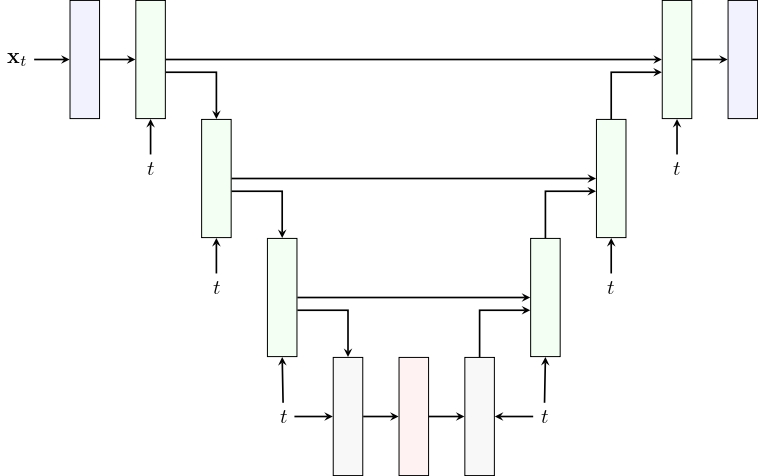




### **Scope of This Section**  

In this section, we will not dive deeply into the **U-Net architecture itself**. Instead, we will focus specifically on how the **time embedding is incorporated** into the network.  


We will use the following class called Block to pass the information of the UNet

In diffusion models, a ResNet block is typically composed of multiple layers to apply time conditioning via **scale-shift normalization** (also called FiLM: feature-wise Linear Modulation ([link to paper](https://arxiv.org/abs/1709.07871))).

The following figure shows the architecture:

<img src='https://drive.google.com/uc?export=view&id=1W48p9bkS5biMBcCWnOJ6wZmp66O6mWdl' width='700'>

and below is a detailed description of each layer:

1. **Initial convolution**

  A standardized convolution is applied to the input to project it into the desired feature space:

  $$
  x_1 = \mathrm{Conv}(x_0)
  $$

2.  **Normalization**

  The input tensor $x$ is normalized using a method such as GroupNorm:

  $$
  x_2 = \mathrm{Norm}(x_1)
  $$

3. **Scale-Shift Modulation**

   A time embedding $t$ is passed through a small MLP $\Phi$ to produce scaling and shifting parameters $\gamma$ and $\beta$, applied channel-wise:

   $$
   (\gamma, \beta) = \Phi(t)
   $$

   These parameters are applied channel-wise to the normalized features:

   $$
   x_3 = (1 + \gamma) \cdot x_2 + \beta
   $$

   It is important that the normalization is done prior to the scale-shift modulation, so that the scale-shift modulation has an effect.

4. **Activation**

   A non-linear activation function (e.g., SiLU or GELU) is applied:

   $$
   x_4 = \mathrm{Activation}(x_3)
   $$

   It comes after the conditioning, to ensure that the activation accounts for the timestep.

5. **Convolution + Normalization + Activation**

   A convolutional layer is applied to propagate local spatial information:

   $$
   x_7 = \mathrm{Activation}(\mathrm{Norm}(\mathrm{Conv}(x_4)))
   $$

6. **Residual Connection**

   The original input is added back to the transformed output. If the number of channels has changed, a linear projection $h(x_0)$ (typically a $1 \times 1$ convolution) is used to align dimensions:

   $$
   \text{output} = h(x_0) + x_7
   \quad \text{or} \quad
   \text{output} = x_0 + x_7
   $$

The residual connection is important because it helps preserve the structure of the data from one step to the next.
Moreover, it allows the network to condition its internal computations on time.
Specifically, it combines:

- the original input (processed without time conditioning), and
- the transformed features (modulated by the time embedding).

This combination allows the block to add time-dependent refinements without discarding the essential spatial or semantic information in the input.


**Hint** : we can use the function:
- `nn.GroupNorm`: torch module that applies group normalization ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.GroupNorm.html))
- `nn.SiLU`: torch module that applies the SiLU activation function ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.SiLU.html))
- `WeightStandardizedConv2d` : our custom module that applies weight standardization to a convolutional layer 


In [ ]:
class Block(nn.Module):
    def __init__(self, dim: int, dim_out: int, groups: int = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(
        self,
        x: torch.Tensor,
        scale_shift: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
    ):
        x = self.proj(x)
        x = self.norm(x)

        if scale_shift:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


**Hint** : you can use the block we defined before and:
- `.chunk()` method : Attempts to split a tensor into the specified number of chunks. Each chunk is a view of the input tensor ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.chunk.html#torch.chunk))
- `nn.Conv2D`: torch module to apply 2D Convolution ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))

In [ ]:
class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim: int, dim_out: int, time_emb_dim: int, groups: int = 8):
        super().__init__()

        self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x: torch.Tensor, time_emb: Optional[torch.Tensor] = None):
        # TODO: implement the forward pass of the ResnetBlock

        scale_shift = None

        if exists(self.mlp) and exists(time_emb):
            # TODO
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            # time_emb = time_emb.view(time_emb.shape[0], time_emb.shape[1], 1, 1)

            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

**Unet**: The Unet architecture is <span style="color:red">given</span>, it incorporates the resnet structure you defined before.


This model is a hierarchical encoder-decoder (UNet) designed for diffusion models. It uses skip connections, attention, and time conditioning via sinusoidal embeddings. Here's a breakdown of each key component:

1. **Stem**: A 1×1 convolution expands the number of channels in the input image. We also keep a copy of this high-resolution feature map to use later for the final skip connection.

2. **Time embedding**: We use sinusoidal positional embeddings to encode timestep information. These embeddings are passed through an MLP, producing a time vector of shape (B, time_dim). This vector modulates all residual blocks via FiLM (Feature-wise Linear Modulation), injecting temporal information.

3. **Encoder**: The encoder reduces spatial resolution while increasing the number of channels. At each level we have: two ResNet block with time conditioning, a linear Attention layer and a downsampling operation. Intermediate activations are saved in a stack h for later use in the decoder.

4. **Bottleneck**: At the lowest spatial resolution: One ResNet block -> Attention -> ResNet block. This is the most compressed representation of the input.

5. **Decoder**: The decoder progressively restores the spatial resolution. At each level: two skip connections from encoder are concatenated, two time-conditioned ResNet blocks, one linear attention layer and an upsampling operation (except at the top level)

6. **Output layer**: The final decoder feature map is merged with the high-res skip from the stem. One last ResNet block refines the output. A 1x1 convolution to project to the desired number of output channels

In [ ]:
class Unet(DiffusionModel):
    """
    Hierarchical encoder-decoder with skip connections + attention,
    conditioned on a sinusoidal time embedding.
    """

    def __init__(
        self,
        dim: int,
        init_dim: Optional[int] = None,
        out_dim: Optional[int] = None,
        dim_mults: Optional[Tuple[int, int, int]] = (1, 1, 2),
        channels: Optional[int] = 1,
        resnet_block_groups: Optional[int] = 4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        input_channels = channels
        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(
            input_channels, init_dim, 1, padding=0
        )  # changed to 1 and 0 from 7,3

        # ---------- resolution schedule -------------------------------------------
        # dims = [64, 64, 64, 128]  for dim=64, dim_mults=(1,1,2)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # ResNet block template with fixed GroupNorm groups
        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # ---------- time embedding MLP --------------------------------------------
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # ---------- encoder (downs) layers ------------------------------------------------
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        # ---------- bottleneck -----------------------------------------------------
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        # ---------- decoder (ups) --------------------------------------------------
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        # ---------- decoder (ups) --------------------------------------------------
        self.out_dim = default(out_dim, channels)
        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x: torch.Tensor, time: torch.Tensor):
        x = self.init_conv(x)

        r = x.clone()

        # -------- time conditioning ----------------------------------------------
        t = self.time_mlp(time)
        h = []

        # -------- encoder ---------------------------------------------------------
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        # -------- bottleneck ------------------------------------------------------
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # -------- decoder ---------------------------------------------------------
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        # -------- final head ------------------------------------------------------
        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


<a id="beta"></a>
### b. Beta schedule


The forward diffusion process progressively adds noise to an image. This noise is introduced according to a known **variance schedule (or beta schedule)** $\beta_t$, which determines the magnitude of noise added at each timestep $t$.


#### Types of beta schedules

The choice of the beta schedule significantly impacts the model's performance. Common schedules include:  
- **Linear beta schedule**  
- **Cosine beta schedule**  
- **Quadratic beta schedule**  
- **Sigmoid beta schedule**  

While it is possible to define a custom beta schedule, it is important to ensure that the noise follows the assumptions required for **sampling from an isotropic Gaussian**, particularly for $p_T$, the final step of the diffusion process.

In [ ]:
def cosine_beta_schedule(timesteps: int, s: float = 0.008) -> torch.Tensor:
    """
    Implements the cosine schedule as proposed in https://arxiv.org/abs/2102.09672

    Args:
        timesteps (int): Number of diffusion steps (T).
        s (float): Offset.

    Returns:
        torch.Tensor: A tensor of shape (timesteps,) containing the beta values.

    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def sigmoid_beta_schedule(timesteps: int) -> torch.Tensor:
    """
    Implements the sigmoid beta schedule

    Args:
        timesteps (int): Number of diffusion steps (T).

    Returns:
        torch.Tensor: A tensor of shape (timesteps,) containing the beta values.

    """
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


#### Implementation of a quadratic beta schedule

Although referred to as "quadratic," this schedule does not perform a true quadratic interpolation. Instead, it is defined as:

$$
\beta_t = \left(\sqrt{\beta_{\text{start}}} + \left(\sqrt{\beta_{\text{end}}} - \sqrt{\beta_{\text{start}}}\right) \cdot \frac{t}{T}\right)^2
$$

where:  
- $\beta_{\text{start}} $ is the initial beta value,  
- $\beta_{\text{end}} $ is the final beta value,
- $ T $ is the total number of timesteps,  
- $ t $ is the current timestep $ t\in [0, T]$.

**Hint** : we can use the function:
- `torch.linspace`: torch implementation similar to numpy linspace ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.linspace.html))

In [ ]:
# TODO implement the quadratic beta schedule.


def quadratic_beta_schedule(timesteps: int) -> torch.Tensor:
    """
    Implements the quadratic beta schedule.

    Args:
        timesteps (int): Number of diffusion steps (T).

    Returns:
        torch.Tensor: A tensor of shape (timesteps,) containing the beta values.
    """
    # TODO
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

#### Implementation of a linear beta schedule

In [ ]:
# TODO implement the linear beta schedule


def linear_beta_schedule(timesteps: int) -> torch.Tensor:
    """
    Implements the linear beta schedule.

    Args:
        timesteps (int): Number of diffusion steps (T).

    Returns:
        torch.Tensor: A tensor of shape (timesteps,) containing the beta values.
    """
    # TODO
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

#### Visualisation

In [ ]:
timesteps = 1001

schedules = {
    "quadratic": quadratic_beta_schedule,
    "linear": linear_beta_schedule,
    "sigmoid": sigmoid_beta_schedule,
    "cosine": cosine_beta_schedule,
}

fig, ax = plt.subplots(1, len(schedules), figsize=(20, 5), sharex=True, sharey=False)

for i, (name, schedule) in enumerate(schedules.items()):
    beta = schedule(timesteps)
    ax[i].plot(beta, label=name)
    ax[i].set_title(name)
    ax[i].set_xlabel("timestep")

ax[0].set_ylabel("beta")
plt.show()

#### Key takeaways

- The quadratic beta schedule ensures a smooth progression of noise variance over time.  
- The interpolation is performed in **square-root space**, ensuring better control over noise scaling.  
- This schedule prevents excessive noise in the early steps while maintaining enough variance for effective learning.  

<a id="forward"></a>
### c. Forward process

#### Introduction

With the **beta schedule** now defined, we can move on to the implementation of the **forward diffusion process**.

Recall the following transition kernel which adds noise to $\mathbf{x}_{t-1}$ to obtain $\mathbf{x}_t$:
$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta(t)} \mathbf{x}_{t-1}, \beta(t) \mathit{\boldsymbol{I}}).
$$

We can efficiently generate a noisy version of the input at any timestep $t$ **without iterating through all previous timesteps** using the following:
$$
q(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathit{\boldsymbol{I}}),
$$

where $\bar{\alpha}_t $ is the **cumulative product** of $(1 - \beta_s)$ up to timestep $t$:
  $$
  \bar{\alpha}_t = \prod_{s=1}^{t} (1 - \beta_s).
  $$

Using the reparameterization trick, we can sample $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{\epsilon}; \mathbf{0}, \mathit{\boldsymbol{I}})$ and set  
$$
\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + (1 - \bar{\alpha}_t) \epsilon.
$$

Note the following:
- The mean $ \sqrt{\bar{\alpha}_t} \mathbf{x}_0 $ ensures that the signal decreases gradually over time,
- The variance term $(1 - \bar{\alpha}_t) \mathit{\boldsymbol{I}} $ ensures that the noise component increases over time.


#### Implementation

**Hint** : You can use the following functions:
- `torch.randn_like` : torch function to generate Gaussian noise of the same size of the input ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.randn_like.html))
- `torch.cumprod`: torch function to do the cumulative product ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.cumprod.html))
- `.view()`: method to reshape a tensor ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.Tensor.view.html))

In [ ]:
# TODO implement the forward process


def q_sample(
    x_0: torch.Tensor,
    t: torch.Tensor,
    betas: torch.Tensor,
    noise: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    Implements the forward process to sample a noisy version of x_0 at timestep t.

    Args:
        x_0 (torch.Tensor): The original clean data (image or feature vector).
        t (torch.Tensor): Timestep tensor (batch of time indices).
        betas (torch.Tensor): Precomputed beta schedule.
        noise (torch.Tensor) or None : Optional tensor of noise to be added. If None, generates noise randomly.

    Returns:
        x_t (torch.Tensor): Noisy version of x_0 at timestep t.
    """
    # TODO
    if noise is None:
        noise = torch.randn_like(x_0, device=x_0.device)

    betas = betas.to(x_0.device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1.0 - alphas_cumprod[t]).view(
        -1, 1, 1, 1
    )

    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

#### Visualisation

In [ ]:
# TODO: play along with the following visualisation code to compare the different beta schedules.

timesteps = 1001

schedules = {
    "quadratic": quadratic_beta_schedule,
    "linear": linear_beta_schedule,
    "sigmoid": sigmoid_beta_schedule,
    "cosine": cosine_beta_schedule,
}

# Timesteps to visualise
test_steps = np.arange(0, 1001, 100)


# Load data sample
transform = transforms.Compose(
    [
        transforms.Lambda(lambda x: torch.rot90(x, dims=(1, 2))),
        transforms.Lambda(
            lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1
        ),  # Normalize the image between -1 and 1,
        transforms.CenterCrop((52, 52)),
    ]
)
index = np.random.randint(0, 10)
x_0 = IXIDataset(img_dir, mode="train", transform=transform)[index]["T1"]

fig, axes = plt.subplots(len(schedules), len(test_steps), figsize=(40, 15))

for i, (name, schedule) in enumerate(schedules.items()):
    betas = schedule(timesteps)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    for j, t in enumerate(test_steps):
        x_t = q_sample(x_0, t, betas)
        axes[i][j].imshow(x_t.squeeze().numpy(), cmap="gray", vmin=-1, vmax=1)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

        if i == 0:
            axes[i][j].set_title(f"t = {t}")

        if j == 0:
            axes[i][j].set_ylabel(name)

plt.show()

In [ ]:
# TODO: play along with the following visualisation code

timesteps = 1001

schedule = quadratic_beta_schedule

# Load data sample
transform = transforms.Compose(
    [
        transforms.Lambda(lambda x: torch.rot90(x, dims=(1, 2))),
        transforms.Lambda(
            lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1
        ),  # Normalize the image between -1 and 1,
        transforms.CenterCrop((52, 52)),
    ]
)
index = np.random.randint(0, 10)
x_0 = IXIDataset(img_dir, mode="train", transform=transform)[index]["T1"]

betas = schedule(timesteps)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

fig = plt.figure()

imgs = []

for t in np.arange(0, timesteps, 5):
    x_t = q_sample(x_0, t, betas)
    imgs.append([plt.imshow(x_t.squeeze().numpy(), cmap="gray", vmin=-1, vmax=1)])
plt.close()
ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True, repeat_delay=1000)


HTML(ani.to_jshtml())

<a id="reverse"></a>
### d. Reverse process (from different perspectives)

#### i. True data predictori

Now, we will define the **data perspective** of the diffusion model by formulating its **training objective**.  

**Defining the Loss Function**  

To train the diffusion model, we use a **mean squared error (MSE) loss** that measures the difference between the original data **$ \mathbf{x}_0 $** and the predicted reconstruction **$ \hat{\mathbf{x}}_{\theta}(\mathbf{x}_t, t) $**. This loss function, known as the **simplified loss** from Ho et al. (2020), is defined as:  

\begin{align}
L_{simple} (\theta) := \mathbb{E}_{t,\mathbf{x}_0,\mathbf{x}_t} \left[ \| \mathbf{x_0} - \hat{\mathbf{x}}_{\theta}(\mathbf{x}_t,t) \|^2 \right]
\end{align}


where:  
- **$ \mathbf{x}_0 $** is the original, clean data sample.  
- **$ \mathbf{x}_t $** is the noisy version of the data at timestep $ t $.  
- **$ \hat{\mathbf{x}}_{\theta}(\mathbf{x}_t, t) $** is the model's prediction of the original data.  
- **$ \mathbb{E}[\cdot] $** denotes expectation over the sampled timesteps and data points.  

**Interpretation of the Loss**  

- This objective encourages the network **$ \hat{\mathbf{x}}_{\theta} $** to learn to reconstruct the original data **$ \mathbf{x}_0 $** given a noisy input **$ \mathbf{x}_t $** at any timestep $ t $.  
- It is a **denoising objective**, meaning that the model gradually learns to remove noise and recover structure from noisy inputs.  
- The expectation is computed over **random timesteps** and **data samples**, ensuring that the model generalizes well across different noise levels.  



In [ ]:
def p_loss_data(
    denoise_model: nn.Module,
    x_0: TensorType["batch", "channel", "width", "height"],
    t: TensorType["batch"],
    betas: TensorType["timesteps"],
) -> torch.Tensor:
    """
    Implements the data perspective loss function.

    Args:
        denoise_model (nn.Module): The denoising model.
        x_0 (torch.Tensor): The original clean data (image or feature vector).
        t (torch.Tensor): Timestep tensor (batch of time indices).
        betas (torch.Tensor): Precomputed beta schedule.
    Returns:
        loss.

    """
    # TODO
    noise = torch.randn_like(x_0, device=x_0.device)

    x_t = q_sample(x_0=x_0, t=t, betas=betas, noise=noise)

    ## reminder the network takes as input x_t  (batch, channels, width, height) and time t (batch,)

    predicted_x0 = denoise_model(x_t, t)

    return F.mse_loss(x_0, predicted_x0)

**Training**  

Now that we have defined the loss function, the next step is to create the training loop

In [ ]:
transform = transforms.Compose(
    [
        transforms.Lambda(lambda x: torch.rot90(x, dims=(1, 2))),
        transforms.Lambda(
            lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1
        ),  # Normalize the image between -1 and 1
        transforms.CenterCrop((52, 52)),
    ]
)

train_dataset = IXIDataset(img_dir, mode="train", transform=transform)

val_dataset = IXIDataset(img_dir, mode="test", transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

image_size = 52
channels = 1

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 1, 2),
)

model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

timesteps = 500
betas = quadratic_beta_schedule(timesteps=timesteps)

epochs = 300  # minimum epochs


**TO DO: complete the training function**

**Hint** : You can use the following functions:
- `torch.randint` Returns a tensor filled with random integers generated uniformly between `low` and `high` ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.randint.html))

In [ ]:
def train(
    p_loss,
    betas,
    model,
    optimizer,
    scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=300,
    model_type="data",
):
    os.makedirs("models", exist_ok=True)

    for epoch in tqdm(range(epochs), desc="epochs", leave=False):
        train_loss = 0
        for step, batch in enumerate(tqdm(train_dataloader, desc="batch", leave=False)):
            optimizer.zero_grad()

            batch = batch["T1"].to(device).to(torch.float32)

            batch_size = batch.shape[0]

            # TODO

            # generate the timestep TensorType"batch"] don't forget to set the device
            # and the type to long

            t = torch.randint(0, timesteps, (batch_size,), device=device).long()

            # compute the loss (p_loss) using the p_loss function (it will take into input the model, batch, t and betas)
            loss = p_loss(model, batch, t, betas)

            loss.backward()
            optimizer.step()

            # until here

            train_loss += loss.item()
            tqdm._instances.clear()

        scheduler.step()

        print(f"train loss: {train_loss / len(train_dataloader)}")

        if epoch % 10 == 0:
            img = model._sample_training(
                (1, 1, *batch.shape[-2:]), timesteps, betas, device, model_type
            )

            plt.figure()
            plt.imshow(img.cpu().squeeze().numpy(), cmap="gray")
            plt.title(f"epoch {epoch}")
            plt.show()
            plt.close()
        torch.save(model.state_dict(), f"models/model_{model_type}.pt")

        if epoch % 5 == 0:
            loss_val = 0
            for step, batch in enumerate(
                tqdm(val_dataloader, desc="validation", leave=False)
            ):
                with torch.no_grad():
                    batch = batch["T1"].to(device).to(torch.float32)

                    batch_size = batch.shape[0]

                    # TODO

                    # generate the timestep

                    t = torch.randint(0, timesteps, (batch_size,), device=device).long()

                    loss = p_loss(model, batch, t, betas)

            loss_val = loss_val / len(val_dataloader.dataset)
            print("Loss val:", loss_val)

<span style="color:red">Warning:</span> Training the network using the data loss is possible, but inefficient and time-consuming. Instead, we will use a pretrained model for sampling.

<span style="color:red">DO NOT TRAIN</span>

In [ ]:
# train(p_loss_data, betas, model, optimizer, scheduler, model_type="data")

##### Discussion about the sampling procedure

Now that we have trained our model, it is time to **sample from an isotropic Gaussian distribution** to generate new data.  

**Reminder: The Role of the Network**  

In our diffusion model, the goal of the network is to **learn the reverse process**, which allows us to gradually remove noise from a pure Gaussian sample until we recover a structured output.  

The reverse process is defined as:  

$$
p_{\theta}(\mathbf{x}_{t-1} \mid \mathbf{x}_t) = \mathcal{N} \left(\mathbf{x}_{t-1}; \boldsymbol \mu_{\theta}(\mathbf{x}_{t},t),\Sigma_q(t) \right)
$$  

where:  
- **$ \mathbf{x}_{t-1} $** is the denoised sample at the previous timestep.  
- **$ \mathbf{x}_t $** is the current noisy sample.  
- **$ \boldsymbol \mu_{\theta}(\mathbf{x}_{t},t) $** is the predicted mean of the distribution.  
- **$ \Sigma_q(t) $** is the variance of the noise, controlling the randomness in the sampling process.  

**Mean Prediction Formula**  

The mean $ \boldsymbol \mu_{\theta}(\mathbf{x}_{t},t) $ is given by:  

$$
\boldsymbol \mu_{\theta}(\mathbf{x}_{t},t) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1}) \mathbf{x}_t + \sqrt{\bar{\alpha}_{t-1}}(1 - \alpha_{t}) \hat{\mathbf{x}}_{\theta}(\mathbf{x}_t,t)}{1 - \bar{\alpha}_{t}}
$$  

where:  
- **$ \alpha_t $** and **$ \bar{\alpha}_t $** are derived from the beta schedule.  
- **$ \hat{\mathbf{x}}_{\theta}(\mathbf{x}_t,t) $** is the model's predicted reconstruction of the clean data.  
- The equation represents a weighted combination of the noisy sample $ \mathbf{x}_t $ and the predicted clean data, ensuring a smooth transition from noise to structure.  

**Variance Term**  

The variance **$ \Sigma_q(t) $** is defined as:  

$$
\Sigma_q(t) = \sigma_q^2(t) \mathit{\boldsymbol I} = \frac{(1 - \alpha_{t})(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_{t}}  \mathit{\boldsymbol I}
$$  

where:  
- **$ \sigma_q^2(t) $** determines the noise level at each step.  
- The term ensures that the noise is reduced gradually over time, stabilizing the sampling process.  


In [ ]:
@torch.no_grad()
def p_sample(
    model: nn.Module,
    x: TensorType["batch", "channel", "width", "height"],
    t: TensorType["batch"],
    betas: TensorType["timesteps"],
) -> torch.Tensor:
    """
    Implements the sampling step from x_t to x_{t-1}.

    Args:
        model (nn.Module): The trained model.
        x_t (torch.Tensor): The original clean data (image or feature vector).
        t (torch.Tensor): Timestep tensor.
        betas (torch.Tensor): Precomputed beta schedule.
    Returns:
        x_{t-1} (torch.Tensor): The denoised sample at the previous timestep.

    """
    # TODO

    t = torch.tensor([t]).to(device)

    betas = betas.to(device)

    # Compute `alphas` as 1 minus `betas`
    alphas = 1.0 - betas

    # Compute the cumulative product of `alphas` along the specified axis
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    # Alternative solutions for the cumprod of t-1

    # Pad the cumulative product of `alphas` (excluding the last element) with 1.0 at the start
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

    # Other solution
    alphas_cumprod_prev = torch.cat(
        [torch.tensor([1.0], device=device), alphas_cumprod[:-1]]
    )

    # Compute the mean of the model output at time `t`
    model_mean = (
        torch.sqrt(alphas[t]) * (1 - alphas_cumprod[t]) * x
        + torch.sqrt(alphas_cumprod_prev[t]) * (1 - alphas[t]) * model(x, t)
    ) / (1 - alphas_cumprod[t])

    # Compute the posterior variance
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

    noise = torch.randn_like(x)

    if t == 0:
        return model_mean
    else:
        return model_mean + torch.sqrt(posterior_variance[t]) * noise


@torch.no_grad()
def p_sample_loop(
    model: nn.Module,
    shape: Tuple,
    betas: TensorType["timesteps"],
    return_all: bool = False,
) -> Union[torch.Tensor, List[torch.Tensor]]:
    """
    Implements the sampling step from noise to x_0.

    Args:
        model (nn.Module): The trained model.
        shape (Tuple): noise shap (batch, channel, width, height).
        betas (torch.Tensor): Precomputed beta schedule.
        return_all (bool): Whether to return all samples timestep or just the last one.
    Returns:
        x_0 (torch.Tensor): The sample data.
        if return_all is True, return a list of all samples timestep

    """

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)

    imgs = []

    # TODO

    for i in tqdm(
        reversed(range(0, len(betas))), desc="sampling loop timestep", total=timesteps
    ):
        img = p_sample(model, img, i, betas)
        if return_all:
            imgs.append(img.cpu().numpy())
    # until here

    if return_all:
        return imgs
    else:
        return img


In [ ]:
# If it was not possible for you to train the network, set pretrained to True
pretrained = True
if pretrained:
    device = "cuda" if torch.cuda.is_available() else "cpu"

    image_size = 52
    channels = 1

    model = Unet(
        dim=image_size,
        channels=channels,
        dim_mults=(1, 1, 2),
    )

    model.to(device)

    timesteps = 500
    betas = quadratic_beta_schedule(timesteps=timesteps)

    model.eval()
    model.load_state_dict(torch.load("model_teacher/model_data.pt", map_location=device))

    img = p_sample_loop(model, shape = (1,1,52,52), betas = betas)

In [ ]:
plt.figure()
plt.imshow(img.squeeze().cpu().numpy(), cmap="gray", vmin = -1, vmax =1)
plt.title("Generated image")
plt.axis("off")
plt.show()

#### ii. Noise predictor

Now, we will define the **noise perspective** of the diffusion model by formulating its **training objective**.  

**Defining the Loss Function**  

We use the reparameterization trick, we can rewrite the forward process as:

\begin{align}
q(\mathbf{x}_{t} \mid \mathbf{x}_{0}) & = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathit{\boldsymbol{I}}) \\
 \mathbf{x}_{t}&  =  \sqrt{\bar{\alpha}_t} \mathbf{x}_{0} +  \sqrt{(1 - \bar{\alpha}_t)} \boldsymbol \epsilon_0, \quad \boldsymbol \epsilon_0 \sim \mathcal{N}(\mathbf{0},\mathit{\boldsymbol I})
\end{align}

So we have:
$$
\mathbf{x}_{0} = \frac{\mathbf{x}_{t} -  \sqrt{(1 - \bar{\alpha}_t)} \boldsymbol \epsilon_0 }{\sqrt{\bar{\alpha}_t}}
$$

The network only needs to predict $ \boldsymbol \epsilon_0$ to predict $\mathbf{x}_{0}$. The network prediction is $\hat{\boldsymbol\epsilon}_{\theta}(\mathbf{x_t},t)$.

To train the diffusion model, we use a **mean squared error (MSE) loss** that measures the difference between the original input noise $\boldsymbol \epsilon_0 \sim \mathcal{N}(\mathbf{0},\mathit{\boldsymbol I})$ and the predicted noise $\hat{\boldsymbol\epsilon}_{\theta}(\mathbf{x_t},t)$.


This loss function, known as the **simplified loss** from Ho et al. (2020), is defined as:  

\begin{align}
L_{simple} (\theta) := \mathbb{E}_{t,\mathbf{x}_0, \boldsymbol\epsilon_0} \left[ \| \boldsymbol \epsilon_0  - \hat{\boldsymbol\epsilon}_{\theta}(\mathbf{x_t},t) \|^2 \right]
\end{align}


where:  
- **$ \mathbf{x}_0 $** is the original, clean data sample.  
- **$ \mathbf{x}_t $** is the noisy version of the data at timestep $ t $.  
- **$ \boldsymbol \epsilon_{\theta}(\mathbf{x_t},t) $** is the model's prediction of the input noise applied to $\mathbf{x}_0$.  
- **$ \mathbb{E}[\cdot] $** denotes expectation over the sampled timesteps, data points and noises.  

**Interpretation of the Loss**  

- This objective encourages the network $ \hat{\boldsymbol\epsilon}_{\theta} $ to learn to reconstruct the original input noise $\boldsymbol \epsilon_0 $ utilized in the forward process to sample $ \mathbf{x}_t $ at any timestep $ t $.  



In [ ]:
def p_loss_noise(
    model: nn.Module,
    x_0: TensorType["batch", "channel", "width", "height"],
    t: TensorType["batch"],
    betas: TensorType["timesteps"],
) -> torch.Tensor:
    """
    Implements the noise perspective loss function.

    Args:
        model (nn.Module): The denoising model.
        x_0 (torch.Tensor): The original clean data (image or feature vector).
        t (torch.Tensor): Timestep tensor (batch of time indices).
        betas (torch.Tensor): Precomputed beta schedule.
    Returns:
        loss.

    """
    # TODO

    noise = torch.randn_like(x_0, device=x_0.device)

    x_t = q_sample(x_0=x_0, t=t, betas=betas, noise=noise)
    predicted_noise = model(x_t, t)

    return F.mse_loss(noise, predicted_noise)

**Training**

We defined the architecture, the betas schedule, the forward process to sample noisy version of the data and the loss. We can now define the training loop

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

image_size = 52
channels = 1

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 1, 2),
)

model.to(device)


optimizer = Adam(
    model.parameters(), lr=1e-4
)  # , betas=(0.9, 0.999),weight_decay = 0.01 )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

timesteps = 500
betas = quadratic_beta_schedule(timesteps=timesteps)

epochs = 300  # minimum epochs

train(
    p_loss_noise,
    betas=betas,
    model_type="noise",
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
)


##### Noise Sampling

Now that we have trained our model, it is time to **sample from an isotropic Gaussian distribution** to generate new data.  

**Reminder: The Role of the Network**  

In our diffusion model, the goal of the network is to **learn the reverse process**, which allows us to gradually remove noise from a pure Gaussian sample until we recover a structured output.  

The reverse process is defined as:  

$$
p_{\theta}(\mathbf{x}_{t-1} \mid \mathbf{x}_t) = \mathcal{N} \left(\mathbf{x}_{t-1}; \boldsymbol \mu_{\theta}(\mathbf{x}_{t},t),\Sigma_q(t) \right)
$$  

where:  
- **$ \mathbf{x}_{t-1} $** is the denoised sample at the previous timestep.  
- **$ \mathbf{x}_t $** is the current noisy sample.  
- **$ \boldsymbol \mu_{\theta}(\mathbf{x}_{t},t) $** is the predicted mean of the distribution.  
- **$ \Sigma_q(t) $** is the variance of the noise, controlling the randomness in the sampling process.  

**Mean Prediction Formula**  

The mean $ \boldsymbol \mu_{\theta}(\mathbf{x}_{t},t) $ is given by:  

$$
\boldsymbol \mu_{\theta}(\mathbf{x}_{t},t) = \frac{1}{\sqrt{\alpha_t}} \mathbf{x}_t - \frac{1 - \alpha_{t}}{\sqrt{1 - \bar{\alpha}_{t}}\sqrt{\alpha_t}} \epsilon_{\theta}(\mathbf{x_t},t)
$$  

where:  
- **$ \alpha_t $** and **$ \bar{\alpha}_t $** are derived from the beta schedule.  
- **$ \epsilon_{\theta}(\mathbf{x_t},t) $** is the model's predicted noise to retreive the clean data.  
- The equation represents a weighted combination of the noisy sample $ \mathbf{x}_t $ and the predicted noise to retreive the clean data, ensuring a smooth transition from noise to structure.  

**Variance Term**  

The variance **$ \Sigma_q(t) $** is defined as:  

$$
\Sigma_q(t) = \sigma_q^2(t) \mathit{\boldsymbol I} = \frac{(1 - \alpha_{t})(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_{t}}  \mathit{\boldsymbol I}
$$  

where:  
- **$ \sigma_q^2(t) $** determines the noise level at each step.  
- The term ensures that the noise is reduced gradually over time, stabilizing the sampling process.  


In [ ]:
# If it was not possible for you to train the network, set pretrained to True
pretrained = False
if pretrained:
    device = "cuda" if torch.cuda.is_available() else "cpu"

    image_size = 52
    channels = 1

    model = Unet(
        dim=image_size,
        channels=channels,
        dim_mults=(1, 1, 2),
    )

    model.to(device)

    timesteps = 500
    betas = quadratic_beta_schedule(timesteps=timesteps)


    model.eval()
    model.load_state_dict(torch.load("model_teacher/model_noise.pt", map_location=device))

In [ ]:
@torch.no_grad()
def p_sample(
    model: nn.Module,
    x: TensorType["batch", "channel", "width", "height"],
    t: TensorType["batch"],
    betas: TensorType["timesteps"],
) -> torch.Tensor:
    """
    Implements the sampling step from x_t to x_{t-1}.

    Args:
        model (nn.Module): The trained model.
        x_t (torch.Tensor): The original clean data (image or feature vector).
        t (torch.Tensor): Timestep tensor.
        betas (torch.Tensor): Precomputed beta schedule.
    Returns:
        x_{t-1} (torch.Tensor): The denoised sample at the previous timestep.
    """

    # TODO

    t = torch.tensor([t]).to(device)
    betas = betas.to(device)

    # Compute `alphas` as 1 minus `betas`
    alphas = 1.0 - betas

    # Compute the cumulative product of `alphas` along the specified axis
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    # Compute the square root of the reciprocal of `alphas`
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # Compute the square root of 1 minus the cumulative product of `alphas` at time `t`
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1.0 - alphas_cumprod[t])

    # Get the value of `sqrt_recip_alphas` at time `t`
    sqrt_recip_alphas_t = sqrt_recip_alphas[t]

    # Compute the mean of the model output at time `t`
    model_mean = sqrt_recip_alphas_t * (
        x - betas[t] * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    # Pad the cumulative product of `alphas` (excluding the last element) with 1.0 at the start
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

    # Compute the posterior variance
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

    noise = torch.randn_like(x)

    if t == 0:
        return model_mean
    else:
        return model_mean + torch.sqrt(posterior_variance[t]) * noise


@torch.no_grad()
def p_sample_loop(
    model: nn.Module,
    shape: Tuple,
    betas: TensorType["timesteps"],
    return_all: bool = False,
) -> Union[torch.Tensor, List[torch.Tensor]]:
    """
    Implements the sampling step from noise to x_0.

    Args:
        model (nn.Module): The trained model.
        shape (Tuple): noise shap (batch, channel, width, height).
        betas (torch.Tensor): Precomputed beta schedule.
        return_all (bool): Whether to return all samples timestep or just the last one.
    Returns:
        x_0 (torch.Tensor): The sample data.
        if return_all is True, return a list of all samples timestep

    """

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)

    imgs = []

    # TODO

    for i in tqdm(
        reversed(range(0, len(betas))), desc="sampling loop timestep", total=timesteps
    ):
        img = p_sample(model, img, i, betas)
        if return_all:
            imgs.append(img.cpu().numpy())

    if return_all:
        return imgs
    else:
        return img


In [ ]:
img = p_sample_loop(model, shape = (10,1,52,52), betas = betas)

In [ ]:
fig = plt.figure(figsize=(5.0, 5.0))

grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(3, 3),  # creates 2x2 grid of Axes
    axes_pad=0.1,  # pad between Axes in inch.
)

for i, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(img[i].cpu().squeeze(), cmap="gray", vmin=-1, vmax=1)

plt.show()

In [ ]:
fig = plt.figure()

ims = []

img = p_sample_loop(model, shape = (1,1,52,52), betas = betas, return_all=True)


for img in imgs:
    ims.append([plt.imshow(img.squeeze(), cmap="gray", vmin=-1, vmax=1)])

plt.close()
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

HTML(ani.to_jshtml())

In [ ]:
ani.save("reverse_process.gif")

#### iii. Score predictor

Now, we will define the **score perspective** of the diffusion model by formulating its **training objective**.  

**Defining the Loss Function**  

Applying the Tweedie's formula on the forward process $q(\mathbf{x}_{t} \mid \mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathit{\boldsymbol{I}})$ :

$$
\mathbb{E} [\boldsymbol \mu_{\mathbf{x}_t} \mid \mathbf{x}_{t}] = \mathbf{x}_{t} + (1-\bar{\alpha}_t) \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)
$$

Thus we have:
$$
 \sqrt{\bar{\alpha}_t} \mathbf{x}_0 = \mathbf{x}_{t} + (1-\bar{\alpha}_t) \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)
$$

and finally:

$$
\mathbf{x}_{0} = \frac{\mathbf{x}_{t} +  (1 - \bar{\alpha}_t) \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t) }{\sqrt{\bar{\alpha}_t}}
$$

The network only need to predict the score $ \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t) $ to predict $\mathbf{x}_{0}$. The network prediction is $\hat{\mathbf{s}}_{\theta}(\mathbf{x_t},t)$.

To train the diffusion model, we use a **mean squared error (MSE) loss** that measures the difference between the true score $\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t) $ and the predicted score $\hat{\mathbf{s}}_{\theta}(\mathbf{x_t},t)$.

The loss is then:   

$$
L_{\text{score}} (\theta) := \mathbb{E}_{t,\mathbf{x}_0, \boldsymbol\epsilon} (1- \bar{\alpha}_t) \left[ \| - \frac{1}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol \epsilon_0 - \hat{\mathbf{s}}_{\theta}(\mathbf{x_t},t) \|^2 \right]
$$  


where:  
- $ \mathbf{x}_0 $ is the original, clean data sample.  
- $ \mathbf{x}_t $ is the noisy version of the data at timestep $ t $.  
- $ \hat{\mathbf{s}}_{\theta}(\mathbf{x_t},t) $ is the model's prediction of the score.  
- $ \mathbb{E}[\cdot] $ denotes expectation over the sampled timesteps, data points and noises.    

But how to compute $\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)$, if you look at the noise predictor diffusion model we can see that you have a relation between the input noise and the score

\begin{align}
\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t) = - \frac{1}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol \epsilon_0
\end{align}

**But we just trained before the noise predictor point of view. So we don't need to retrain the model. We can directly use the previous equation for the sampling.**





##### Score Sampling  

Now that we have trained our model, it is time to **sample from an isotropic Gaussian distribution** to generate new data.  

**Reminder: The Role of the Network**  

In our diffusion model, the goal of the network is to **learn the reverse process**, which allows us to gradually remove noise from a pure Gaussian sample until we recover a structured output.  

The reverse process is defined as:  

$$
p_{\theta}(\mathbf{x}_{t-1} \mid \mathbf{x}_t) = \mathcal{N} \left(\mathbf{x}_{t-1}; \boldsymbol \mu_{\theta}(\mathbf{x}_{t},t),\Sigma_q(t) \right)
$$  

where:  
- **$ \mathbf{x}_{t-1} $** is the denoised sample at the previous timestep.  
- **$ \mathbf{x}_t $** is the current noisy sample.  
- **$ \boldsymbol \mu_{\theta}(\mathbf{x}_{t},t) $** is the predicted mean of the distribution.  
- **$ \Sigma_q(t) $** is the variance of the noise, controlling the randomness in the sampling process.  

**Mean Prediction Formula**  

The mean $ \boldsymbol \mu_{\theta}(\mathbf{x}_{t},t) $ is given by:  

$$
\boldsymbol \mu_{\theta}(\mathbf{x}_{t},t) = \frac{1}{\sqrt{\alpha_t}} \mathbf{x}_t + \frac{1 - \alpha_{t}}{\sqrt{\alpha_t}} \mathbf{s}_{\theta}(\mathbf{x_t},t)
$$  

where:  
- **$ \alpha_t $** and **$ \bar{\alpha}_t $** are derived from the beta schedule.  
- **$ \mathbf{s}_{\theta}(\mathbf{x_t},t) $** is the model's predicted of the score (e.g $\nabla \log p(\mathbf{x}_t)$).
- The equation represents a weighted combination of the noisy sample $ \mathbf{x}_t $ and the score, ensuring a smooth transition from noise to structure.  

**Variance Term**  

The variance **$ \Sigma_q(t) $** is defined as:  

$$
\Sigma_q(t) = \sigma_q^2(t) \mathit{\boldsymbol I} = \frac{(1 - \alpha_{t})(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_{t}}  \mathit{\boldsymbol I}
$$  

where:  
- **$ \sigma_q^2(t) $** determines the noise level at each step.  
- The term ensures that the noise is reduced gradually over time, stabilizing the sampling process.  


It was just an introduction to the score but it opens the road to the Score based model using Stochastic Differential Equation. [Song et al, 2021]

In [ ]:
@torch.no_grad()
def p_sample(
    model: nn.Module,
    x: TensorType["batch", "channel", "width", "height"],
    t: TensorType["batch"],
    betas: TensorType["timesteps"],
) -> torch.Tensor:
    """
    Implements the sampling step from x_t to x_{t-1}.

    Args:
        model (nn.Module): The trained model.
        x_t (torch.Tensor): The original clean data (image or feature vector).
        t (torch.Tensor): Timestep tensor.
        betas (torch.Tensor): Precomputed beta schedule.
    Returns:
        x_{t-1} (torch.Tensor): The denoised sample at the previous timestep.
    """
    # TO DO

    t = torch.tensor([t]).to(device)
    betas = betas.to(device)

    # Compute `alphas` as 1 minus `betas`
    alphas = 1.0 - betas

    # Compute the cumulative product of `alphas` along the specified axis
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    # Compute the square root of the reciprocal of `alphas`
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # Compute the square root of 1 minus the cumulative product of `alphas` at time `t`
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1.0 - alphas_cumprod[t])

    # Get the value of `sqrt_recip_alphas` at time `t`
    sqrt_recip_alphas_t = sqrt_recip_alphas[t]

    # compute the score:
    eps = model(x, t)
    score = -eps / sqrt_one_minus_alphas_cumprod_t

    # Compute the mean of the model output at time `t`
    model_mean = sqrt_recip_alphas_t * (x + betas[t] * score)

    # Pad the cumulative product of `alphas` (excluding the last element) with 1.0 at the start
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

    # Compute the posterior variance
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

    noise = torch.randn_like(x)

    if t == 0:
        return model_mean
    else:
        return model_mean + torch.sqrt(posterior_variance[t]) * noise


@torch.no_grad()
def p_sample_loop(
    model: nn.Module,
    shape: Tuple,
    betas: TensorType["timesteps"],
    return_all: bool = False,
) -> Union[torch.Tensor, List[torch.Tensor]]:
    """
    Implements the sampling step from noise to x_0.

    Args:
        model (nn.Module): The trained model.
        shape (Tuple): noise shap (batch, channel, width, height).
        betas (torch.Tensor): Precomputed beta schedule.
        return_all (bool): Whether to return all samples timestep or just the last one.
    Returns:
        x_0 (torch.Tensor): The sample data.
        if return_all is True, return a list of all samples timestep

    """

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)

    imgs = []

    for i in tqdm(
        reversed(range(0, timesteps)), desc="sampling loop timestep", total=timesteps
    ):
        img = p_sample(model, img, i, betas)
        if return_all:
            imgs.append(img.cpu().numpy())

    if return_all:
        return imgs
    else:
        return img


In [ ]:
img = p_sample_loop(model, shape = (10,1,52,52), betas = betas)

In [ ]:
fig = plt.figure(figsize=(5.0, 5.0))

grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(3, 3),  # creates 3x3 grid of Axes
    axes_pad=0.1,  # pad between Axes in inch.
)

for i, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(img[i].cpu().squeeze(), cmap="gray", vmin=-1, vmax=1)

plt.show()

<a id="anomdetect"></a>
## 4. Application to anomaly detection with anoDDPM

### Introduction

In this section, we are going to use a diffusion model to solve an unsupervised medical anomaly detection task. 
We will be working with brain FLAIR (fluid attenuated inversion recovery) MRI from the BraTS dataset, attempting to detect tumors. 
In terms of model, we will be recreating the famous AnoDDPM, a diffusion model specifically designed for medical anomaly detection. 

**Unsupervised anomaly detection via pseudo-healthy reconstruction**

We will be doing unsupervised anomaly detection, meaning that we will learn to detect anomalies from unlabelled data, i.e. no segmentation masks, just a single label per image indicating whether the image is normal or abnormal.
The idea is to learn the distribution of normal data by training our diffusion model only with healthy data. 
Once the model is trained, at inference time, we can give as input to our model any image (pathological or not), and the model will output a pseudo-healthy version of that image. 
By comparing the real image with its pseudo-healthy version outputted by the model, for example by looking at the difference between the two images, we obtain an anomaly map from which we can precisely localise anomalies. 

**AnoDDPM**

AnoDDPM is a denoising diffusion probabilistic model (DDPM) with simplex noise (instead of isotropic Gaussian noise). 
You might be interested in the following links: 
- an overview of the framework: https://julianwyatt.co.uk/anoddpm, 
- the official code repository: https://github.com/Julian-Wyatt/AnoDDPM, 
- and the CVPR workshop 2022 paper: https://openaccess.thecvf.com/content/CVPR2022W/NTIRE/html/Wyatt_AnoDDPM_Anomaly_Detection_With_Denoising_Diffusion_Probabilistic_Models_Using_Simplex_CVPRW_2022_paper.html. 

**Data splitting**

We need to separate data between normal (or healthy) for training and abnormal (or pathological) for both training and testing. 
Since all images in BraTS are pathological, we divide between healthy slices and pathological slices.
To avoid data leakage, we ensure that all slices for a given subject are either in the training set or in the testing set. 

Note, separating slices between pathological and healthy is not good practice for the following reason: 
- slices labelled as healthy might not be truly healthy, for instance, if located close to a tumor, the tissue might be deformed,
- healthy slices tend to be more frequent towards the edge of the brain, and pathological slices more frequent towards the center of the brain, inducing a localisation bias.

**Evaluation**

We will be evaluating the following: 
1. Given a healthy image, the model outputs a healthy image, that closely ressembles the input. We evaluate this using similarity metrics such as the [Structural Similarity Index Measure](https://en.wikipedia.org/wiki/Structural_similarity_index_measure) (Wang et al., 2004)[https://ieeexplore.ieee.org/document/1284395], and the mean squared error (MSE). 
2. Given an abnormal image, we check that the anomaly map is close to the tumor segmentation mask. Since the anomaly maps are unthresholded, we will use the pixelwise Average Precision (AP) and the best possible Dice over a range of possible thresholds ($\lceil \text{Dice} \rceil$). 

**BraTS**

Our dataset comes from the [Brain Tumor Segmentation Challenge (BraTS)](https://www.cancerimagingarchive.net/analysis-result/rsna-asnr-miccai-brats-2021/) from 2021, generated by the TCGA Research Network: http://cancergenome.nih.gov/ and obtained as part of the RSNA-ASNR-MICCAI Brain Tumor Segmentation (BraTS) Challenge project through Synapse ID (syn25829067). 

For more information regarding the dataset and the challenge, you can consult the following papers: 

- [1] U.Baid, et al., The RSNA-ASNR-MICCAI BraTS 2021 Benchmark on Brain Tumor Segmentation and Radiogenomic Classification, 2021, [(arXiv:2107.02314)](https://arxiv.org/abs/2107.02314).
- [2] B. H. Menze, A. Jakab, S. Bauer, J. Kalpathy-Cramer, K. Farahani, J. Kirby, et al. "The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS)", IEEE Transactions on Medical Imaging 34(10), 1993-2024 (2015) [DOI: 10.1109/TMI.2014.2377694](https://doi.org/10.1109/tmi.2014.2377694).


### Loading the dataset

In [ ]:
root_dir = "BraTS2021"

abnormal_dataset = Subset(
    BraTSDataset(
        root_dir,
        mode="test",
        test_type="abnormal",
        transform=transforms.Lambda(
            lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1
        ),
    ),
    range(30),
)

abnormal_sample = abnormal_dataset[60]

fig, axes = plt.subplots(1, 2)

axes[0].imshow(abnormal_sample["img"].squeeze(), cmap="gray")
axes[0].axis("off")
axes[0].set_title("Abnormal scan")

axes[1].imshow(abnormal_sample["mask"].squeeze(), cmap="gray")
axes[1].axis("off")
axes[1].set_title("Anomaly segmentation")

plt.show()

### Simplex noise

**Perlin/Simplex** noise is a smooth, pseudo-random function invented by Ken Perlin. It is used to generate natural-looking textures (e.g., clouds, terrain).

The difference between Perlin and Simplex is that Simplex uses triangles lattices in 2D rather than Perlin that uses square lattices. 
In order to make the computation faster for this lab session, we will use Perlin noise.

This noise can be seen as “randomness with memory”, it changes smoothly rather than abruptly like Gaussian noise.
It is a gradient-based noise: instead of assigning random values to grid points, it assigns random gradients (directions), and interpolates between them.

The parameters are:

- **octaves**: number of noise layers (frequencies) summed (more octaves means more details)
- **persistence**: controls the amplitude reduction between the octaves

It has been shown in practice that this noise produces better results than Gaussian noise on medical imaging, since it looks closer to real-world anomalies that we find in medical imaging data.

It might be worth noting, that at the beginning of this practical session, we mentionned the following two assumptions: 
- $x_T$ must be close to an isotropic Gaussian distribution, 
- and each forward step is Gaussian . 

Using a simplex noise violates both of these assumptions, yet empirically, everything works anyways! 

In [ ]:
x = torch.randn((1, 1, 128, 128))
t = torch.rand((1,))

simplex_noise = rand_perlin_2d_octaves(x.shape, res=(1, 1), octaves=6, persistence=0.8)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(torch.randn((128, 128)).squeeze().numpy())
axes[0].set_title("Gaussian Noise")

axes[1].imshow(simplex_noise.squeeze().numpy())
axes[1].set_title("Perlin Noise")
axes[0].axis("off")
axes[1].axis("off")


In [ ]:
# TODO: play along with the following visualisation code to compare the different beta schedules.

timesteps = 1001

schedules = {
    "quadratic": quadratic_beta_schedule,
    "linear": linear_beta_schedule,
    "sigmoid": sigmoid_beta_schedule,
    "cosine": cosine_beta_schedule,
}

# Timesteps to visualise
test_steps = np.arange(0, 1001, 100)


index = np.random.randint(0, 10)
x_0 = abnormal_sample["img"].unsqueeze(0)

fig, axes = plt.subplots(len(schedules), len(test_steps), figsize=(40, 15))

for i, (name, schedule) in enumerate(schedules.items()):
    betas = schedule(timesteps)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    for j, t in enumerate(test_steps):
        x_t = q_sample(
            x_0,
            t,
            betas,
            noise=rand_perlin_2d_octaves(
                x_0.shape, res=(1, 1), octaves=8, persistence=0.8
            ),
        )
        axes[i][j].imshow(x_t.squeeze().numpy(), cmap="gray", vmin=-1, vmax=1)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

        if i == 0:
            axes[i][j].set_title(f"t = {t}")

        if j == 0:
            axes[i][j].set_ylabel(name)

plt.show()

### Putting everything together

We will be putting everything together in a single object class called `AnoDDPMDiffusionModel` that contains methods to perform the forward pass, the sampling and compute the loss. 
For the loss we will use the noise predictor. 

We will have to do the following steps:
- implement the forward process method `q_sample` (use similar functions as in previous sections, nothing changes apart from the noise), 
- implement the `noise_loss` method which will be use for the training,
- and implement the sampling part, using the method `p_sample`. 

If we were to generate new data samples (as in typical generative modelling frameworks), we would use `p_sample` from pure Simplex noise. 
In our case, we are interested in obtaining a pseudo-healthy reconstruction for a given specific image $x_0$, so we noise the image up to given a timestep $\lambda$ (to be determined) to obtain $x_\lambda$, which we then give as input to the reverse process through `p_sample` to obtain a subject-specific pseudo-healthy reconstruction. 

In [ ]:
class AnoDDPMDiffusionModel(nn.Module):
    """
    A simple diffusion model that can be used to train and sample from a diffusion process.
    """

    def __init__(
        self, Unet, timesteps: int = 500, beta_fn=None, noise_type: str = "gauss"
    ):
        super().__init__()

        self.network = Unet
        self.timesteps = timesteps
        self.beta_fn = beta_fn
        self.noise_type = noise_type

        if beta_fn is None:
            self.betas = quadratic_beta_schedule(self.timesteps)
        else:
            self.betas = betas

        if self.noise_type == "gauss":
            self.noise_fn = lambda x: torch.randn_like(x, device=x.device)
        elif self.noise_type == "simplex":
            self.noise_fn = lambda x: rand_perlin_2d_octaves(
                shape=x.shape, res=(1, 1), octaves=8, persistence=0.8
            ).to(x.device)

    def q_sample(
        self,
        x_0: TensorType["batch", "channel", "width", "height"],
        t: TensorType["batch"],
        noise: Optional[torch.Tensor] = None,
    ) -> TensorType["batch", "channel", "width", "height"]:
        """
        Samples a noisy version of x_0 at timestep t.

        Args:
            x_0 (torch.Tensor): The original clean data (image or feature vector).
            t (torch.Tensor): Timestep tensor (batch of time indices).
            noise (torch.Tensor) or None : Optional tensor of noise to be added. If None, generates noise randomly.

        Returns:
            torch.Tensor: Noisy version of x_0 at timestep t.
        """
        # TODO

        if noise is None:
            noise = self.noise_fn(x_0)

        betas = self.betas.to(x_0.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1.0 - alphas_cumprod[t]).view(
            -1, 1, 1, 1
        )

        return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

    def noise_loss(self, x_0: torch.Tensor) -> torch.Tensor:
        # TODO

        t = torch.randint(0, self.timesteps, (x_0.size(0),), device=x_0.device).long()
        noise = self.noise_fn(x_0)
        x_t = self.q_sample(x_0=x_0, t=t, noise=noise)
        predicted_noise = self.network(x_t, t)

        return F.mse_loss(noise, predicted_noise)

    @torch.no_grad()
    def p_sample(self, x_t: torch.Tensor, t: int) -> torch.Tensor:
        """
        Samples from the diffusion model at a specific timestep.

        Args:
            x_t (torch.Tensor): The noisy data at timestep t.
            t (int): The current timestep.

        Returns:
            torch.Tensor: The denoised sample at the previous timestep.
        """
        t = torch.tensor([t]).to(x_t.device)

        # TODO

        betas = self.betas.to(x_t.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

        # Compute the cumulative product of `alphas` along the specified axis
        alphas_cumprod = torch.cumprod(alphas, axis=0)

        # Compute the square root of the reciprocal of `alphas`
        sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

        sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1.0 - alphas_cumprod[t])

        # Get the value of `sqrt_recip_alphas` at time `t`
        sqrt_recip_alphas_t = sqrt_recip_alphas[t]

        # Compute the mean of the model output at time `t`
        model_mean = sqrt_recip_alphas_t * (
            x_t - betas[t] * self.network(x_t, t) / sqrt_one_minus_alphas_cumprod_t
        )

        # Pad the cumulative product of `alphas` (excluding the last element) with 1.0 at the start
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

        # Compute the posterior variance
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )

        noise = self.noise_fn(x_t)

        if t == 0:
            return model_mean
        else:
            return model_mean + torch.sqrt(posterior_variance[t]) * noise

    @torch.no_grad()
    def predict(self, x_0: torch.Tensor, start_timestep) -> torch.Tensor:
        """
        Samples from the diffusion model.

        Args:
            x_0 (torch.Tensor): The original image (image or feature vector).
            start_timestep (int): The starting timestep for sampling.
        Returns:
            torch.Tensor: The generated sample(s).
        """
        # TODO

        x_t = self.q_sample(
            x_0=x_0,
            t=torch.tensor([start_timestep]).to(x_0.device),
            noise=self.noise_fn(x_0),
        )

        for i in tqdm(
            reversed(range(0, start_timestep)),
            desc="sampling loop",
            total=start_timestep,
        ):
            x_t = self.p_sample(x_t, i)

        return x_t

### Training

We are now going to train, just launch the training

In [ ]:
normal_dataset = BraTSDataset(
    root_dir,
    mode="train",
    transform=transforms.Lambda(lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1),
)


train_dataloader = DataLoader(normal_dataset, batch_size=10, shuffle=True)

unet = Unet(dim=64, channels=1, dim_mults=(1, 1, 2))

model = AnoDDPMDiffusionModel(
    Unet=unet,
    timesteps=timesteps,
    beta_fn=quadratic_beta_schedule,
    noise_type="simplex",
)


def train(model, train_dataloader, epochs=10, device="cuda"):
    """
    Trains the diffusion model.

    Args:
        model (DiffusionModel): The diffusion model to train.
        train_dataloader (DataLoader): DataLoader for training data.
        epochs (int): Number of training epochs.
        device (str): Device to use for training ("cuda" or "cpu").
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for batch_idx, batch in enumerate(
            tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
        ):
            x_0 = batch["img"].to(device).float()

            optimizer.zero_grad()
            loss = model.noise_loss(x_0)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if (batch_idx + 1) % 100 == 0:
                print(
                    f"Epoch [{epoch + 1}/{epochs}], Step [{batch_idx + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}"
                )
        avg_loss = total_loss / len(train_dataloader)

        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

        torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pt")


train(model, train_dataloader, epochs=40, device="cuda")

### Inference

We are now going to predict, just launch the inference.

In [ ]:
model.eval()
model.to("cuda")

x_0 = abnormal_sample["img"].unsqueeze(0).to("mps:0").float()
seg = abnormal_sample["mask"].unsqueeze(0).to("mps:0").float()

start_timestep = 240
generated_sample = model.predict(x_0, start_timestep)


fig, axes = plt.subplots(1, 4, figsize=(10, 5))
seg = abnormal_sample["mask"].unsqueeze(0).to("mps:0").float()

axes[0].imshow(x_0.squeeze().cpu().numpy(), cmap="gray", vmin=-1, vmax=1)
axes[0].axis("off")
axes[0].set_title("Original Image")
x
axes[1].imshow(generated_sample.squeeze().cpu().numpy(), cmap="gray", vmin=-1, vmax=1)
axes[1].axis("off")
axes[1].set_title("Generated Sample")

axes[2].imshow(seg.squeeze().cpu().numpy(), cmap="seismic", vmin=-1, vmax=1)
axes[2].set_title("Segmentation Mask")
axes[2].axis("off")

axes[3].imshow(
    (x_0.squeeze() - generated_sample.squeeze()).pow(2).cpu().numpy(), cmap="seismic"
)
axes[3].set_title("Difference")
axes[3].axis("off")

### Evaluation

**Dice**

The Dice score (also known as the Dice Similarity Coefficient, DSC) is a statistical metric used to measure the overlap between two sets. 
It is commonly used in image segmentation tasks to quantify how well the predicted segmentation matches the ground truth.

Given two binary sets $A$ and $B$ (e.g., predicted and ground truth masks), the Dice score is defined as:

$$
\mathrm{Dice}(A,B) = \frac{2 | A \cap B |}{ |A| + |B|}
$$

In terms of true positives (TP), false positives (FP), and false negatives (FN), for binary classification, it can be written as:

$$
\mathrm{Dice} = \frac{2 TP}{ 2 TP + FP + FN}
$$

The score ranges from 0 (no overlap) to 1 (perfect overlap).

For a deeper explanation follow: https://metrics-reloaded.dkfz.de/metric?id=dsc

**Best Dice ($\lceil \text{Dice} \rceil$)**

Since our anomaly maps are unthresholded, we can't directly computing the Dice score from them, as it requires binary maps. 
One possibility would be to binarise the maps, using a threshold that we could define. 
Another possibility is to use metrics that do not strongly rely on thresholds. 

The Best Dice, or $\lceil \text{Dice} \rceil$, is an estimate of the best possible Dice for any given threshold. 
In practice, we iterate other thresholds, binarise the anomaly map for each threshold and compute the corresponding Dice score. 
The $\lceil \text{Dice} \rceil$ corresponds to the maximum Dice obtained across all thresholds.


**Pixelwise Average Precision (AP)**

The Average Precision (AP) is a widely used metric in object detection, segmentation, and retrieval tasks. 
It summarizes the precision-recall curve as the area under the curve, giving a single number that captures the trade-off between precision and recall across different thresholds.

Formally, 
$$\text{precision} = \frac{\text{TP}}{\text{TP}+\text{FN}} = \mathbb{P}[\hat{y} = 1 | y = 1], \quad \text{recall} = \frac{\text{TP}}{\text{TP}+\text{FP}} = \mathbb{P}[y = 1 | \hat{y} = 1],$$

and if we denote by $P_n, R_n$ the precision and recall at the $n$-th threshold: 

$$AP = \sum_n (R_n - R_{n-1}) P_n.$$

For more explanation, you can go check the [scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). 

In [ ]:
# from https://github.com/iolag/UPD_study/blob/main/UPD_study/utilities/metrics.py


def compute_dice(preds: np.ndarray, targets: np.ndarray) -> float:
    """
    Computes the Sorensen-Dice coefficient:

    dice = 2 * TP / (2 * TP + FP + FN)

    :param preds: An array of predicted anomaly scores.
    :param targets: An array of ground truth labels.
    """
    preds, targets = np.array(preds), np.array(targets)

    # Check if predictions and targets are binary
    if not np.all(np.logical_or(preds == 0, preds == 1)):
        raise ValueError("Predictions must be binary")
    if not np.all(np.logical_or(targets == 0, targets == 1)):
        raise ValueError("Targets must be binary")

    # Compute Dice
    dice = 2 * np.sum(preds[targets == 1]) / (np.sum(preds) + np.sum(targets))

    return dice


def compute_best_dice(
    preds: np.ndarray,
    targets: np.ndarray,
    n_thresh: float = 100,
    num_processes: int = 4,
) -> Tuple[float, float]:
    """
    Compute the best dice score for n_thresh thresholds.

    :param predictions: An array of predicted anomaly scores.
    :param targets: An array of ground truth labels.
    :param n_thresh: Number of thresholds to check.
    """
    preds, targets = np.array(preds), np.array(targets)

    thresholds = np.linspace(preds.max(), preds.min(), n_thresh)

    with Pool(num_processes) as pool:
        fn = partial(_dice_multiprocessing, preds, targets)
        scores = pool.map(fn, thresholds)

    scores = np.stack(scores, 0)
    max_dice = scores.max()
    max_thresh = thresholds[scores.argmax()]
    return max_dice, max_thresh


def _dice_multiprocessing(
    preds: np.ndarray, targets: np.ndarray, threshold: float
) -> float:
    return compute_dice(np.where(preds > threshold, 1, 0), targets)


def compute_average_precision(predictions, targets):
    """
    Compute Average Precision
    Args:
        predictions (torch.Tensor): Anomaly scores
        targets (torch.Tensor): Segmentation map or target label, must be binary
    """
    if (targets - targets.int()).sum() > 0.0:
        raise RuntimeError("targets for AP must be binary")
    ap = average_precision_score(targets.reshape(-1), predictions.reshape(-1))
    return ap

In [ ]:
pred_mask = (generated_sample > 0.3).float()
target_mask = (seg > 0.1).float()
dice = compute_best_dice(pred_mask, target_mask)
print(f"Dice Score: {dice.item():.4f}")

In [ ]:
ap = compute_average_precision(pred_mask, target_mask)
print(f"Average Precision (AP) at pixel level: {ap.item():.4f}")

We can now evaluate on the test set how is performing the model.

In [ ]:
test_loader = DataLoader(abnormal_dataset, batch_size=15, shuffle=False)


def evaluation(
    model,
    test_dataloader,
    start_timestep=200,
    device="cuda",
):
    """AnoDDPM evaluation function.

    Args:
        model (AnoDDPMDiffusionModel): The trained AnoDDPM model.
        test_dataloader (DataLoader): DataLoader for test data.
        device (str): Device to use for evaluation ("cuda" or "cpu").
    Returns:
        dict: A dictionary containing the average Dice score and Average Precision (AP) score.
    """

    model.eval()
    model.to(device)

    dice_scores = []
    ap_scores = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            x_0 = batch["img"].to(device).float()
            seg = batch["mask"].to(device).float()

            # Generate sample
            generated_sample = model.predict(x_0, start_timestep=start_timestep)

            for i in range(len(generated_sample)):
                sample = generated_sample[i]

                # Compute residual
                residual = x_0[i].squeeze() - sample.squeeze()
                seg_sample = seg[i].squeeze()

                # Compute Dice score
                pred_mask = (residual.pow(2) > 0.1).float()
                target_mask = (seg_sample > 0.1).float()
                dice = compute_dice(pred_mask, target_mask)
                dice_scores.append(dice)

                # Compute Average Precision (AP)
                ap = compute_average_precision(residual.pow(2), target_mask)
                ap_scores.append(ap)

    return pd.DataFrame(
        {"Dice Score": dice_scores, "Average Precision (AP)": ap_scores}
    )


results = evaluation(model, test_loader, device="cuda")